# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.8012132228154445 -2.6249683405741777
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    #targetQs = tf.reshape(targetQs, shape=[-1, 1])
    #Qs_labels = tf.concat(axis=0, values=[targetQs[1:], tf.zeros(shape=[1, 1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(targetQs[1:])))
    # targetQs = tf.reshape(targetQs, shape=[-1, 1])
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [25]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode:0 meanR:8.0000 rate:0.0160 gloss:0.0347 dloss:1.4095 dlossR:0.7169 dlossQ:0.6927
Episode:1 meanR:8.5000 rate:0.0180 gloss:-0.0001 dloss:1.3858 dlossR:0.6927 dlossQ:0.6931
Episode:2 meanR:8.6667 rate:0.0180 gloss:-0.0379 dloss:1.3555 dlossR:0.6630 dlossQ:0.6925
Episode:3 meanR:8.7500 rate:0.0180 gloss:-0.0751 dloss:1.3263 dlossR:0.6356 dlossQ:0.6907
Episode:4 meanR:8.8000 rate:0.0180 gloss:-0.1227 dloss:1.2912 dlossR:0.6041 dlossQ:0.6870
Episode:5 meanR:9.0000 rate:0.0200 gloss:-0.1722 dloss:1.2563 dlossR:0.5747 dlossQ:0.6816
Episode:6 meanR:9.1429 rate:0.0200 gloss:0.0264 dloss:1.4030 dlossR:0.7112 dlossQ:0.6918
Episode:7 meanR:9.2500 rate:0.0200 gloss:0.0124 dloss:1.3932 dlossR:0.7010 dlossQ:0.6923
Episode:8 meanR:9.1111 rate:0.0160 gloss:-0.0301 dloss:1.3572 dlossR:0.6646 dlossQ:0.6926
Episode:9 meanR:9.1000 rate:0.0180 gloss:-0.0420 dloss:1.3484 dlossR:0.6561 dlossQ:0.6923
Episode:10 meanR:9.1818 rate:0.0200 gloss:-0.0776 dloss:1.3183 dlossR:0.6275 dlossQ:0.6907
Episode:11 m

Episode:93 meanR:36.0851 rate:0.7900 gloss:-1.9739 dloss:2.5468 dlossR:2.3256 dlossQ:0.2213
Episode:94 meanR:36.4947 rate:0.1500 gloss:-1.8936 dloss:0.7049 dlossR:0.4754 dlossQ:0.2295
Episode:95 meanR:36.8854 rate:0.1480 gloss:-1.9529 dloss:0.6948 dlossR:0.4787 dlossQ:0.2161
Episode:96 meanR:37.2990 rate:0.1540 gloss:-2.0005 dloss:0.7093 dlossR:0.5036 dlossQ:0.2057
Episode:97 meanR:37.0714 rate:0.0300 gloss:-1.8223 dloss:0.3953 dlossR:0.1494 dlossQ:0.2459
Episode:98 meanR:36.8283 rate:0.0260 gloss:-1.8748 dloss:0.3712 dlossR:0.1367 dlossQ:0.2344
Episode:99 meanR:36.5500 rate:0.0180 gloss:-2.0033 dloss:0.3204 dlossR:0.1113 dlossQ:0.2091
Episode:100 meanR:36.5900 rate:0.0240 gloss:-2.0631 dloss:0.3244 dlossR:0.1264 dlossQ:0.1981
Episode:101 meanR:36.5900 rate:0.0180 gloss:-1.9573 dloss:0.3347 dlossR:0.1150 dlossQ:0.2197
Episode:102 meanR:36.6000 rate:0.0200 gloss:-1.8791 dloss:0.3585 dlossR:0.1229 dlossQ:0.2356
Episode:103 meanR:36.9700 rate:0.0920 gloss:-1.6524 dloss:0.5950 dlossR:0.307

Episode:193 meanR:49.7900 rate:0.1360 gloss:-1.9227 dloss:0.6696 dlossR:0.4424 dlossQ:0.2272
Episode:194 meanR:49.5300 rate:0.0980 gloss:-2.0442 dloss:0.5619 dlossR:0.3495 dlossQ:0.2124
Episode:195 meanR:50.0000 rate:0.2420 gloss:-1.8292 dloss:0.9530 dlossR:0.7110 dlossQ:0.2420
Episode:196 meanR:49.7700 rate:0.1080 gloss:-1.8176 dloss:0.5981 dlossR:0.3545 dlossQ:0.2436
Episode:197 meanR:50.0200 rate:0.0800 gloss:-1.8399 dloss:0.5189 dlossR:0.2810 dlossQ:0.2380
Episode:198 meanR:50.1400 rate:0.0500 gloss:-1.8216 dloss:0.4434 dlossR:0.2010 dlossQ:0.2424
Episode:199 meanR:50.3400 rate:0.0580 gloss:-1.8447 dloss:0.4594 dlossR:0.2221 dlossQ:0.2374
Episode:200 meanR:50.4500 rate:0.0460 gloss:-1.8434 dloss:0.4276 dlossR:0.1900 dlossQ:0.2376
Episode:201 meanR:50.6100 rate:0.0500 gloss:-1.9105 dloss:0.4220 dlossR:0.1995 dlossQ:0.2225
Episode:202 meanR:50.6600 rate:0.0300 gloss:-1.9212 dloss:0.3649 dlossR:0.1439 dlossQ:0.2209
Episode:203 meanR:50.4000 rate:0.0400 gloss:-1.9724 dloss:0.3815 dloss

Episode:286 meanR:37.5300 rate:0.0380 gloss:-1.6400 dloss:0.4779 dlossR:0.1822 dlossQ:0.2957
Episode:287 meanR:37.5900 rate:0.0320 gloss:-1.7021 dloss:0.4436 dlossR:0.1641 dlossQ:0.2794
Episode:288 meanR:37.6000 rate:0.0260 gloss:-1.8165 dloss:0.3935 dlossR:0.1428 dlossQ:0.2507
Episode:289 meanR:37.5800 rate:0.0200 gloss:-1.8506 dloss:0.3702 dlossR:0.1269 dlossQ:0.2433
Episode:290 meanR:37.5800 rate:0.0180 gloss:-1.9525 dloss:0.3417 dlossR:0.1183 dlossQ:0.2235
Episode:291 meanR:37.5700 rate:0.0180 gloss:-1.9599 dloss:0.3401 dlossR:0.1179 dlossQ:0.2222
Episode:292 meanR:37.5500 rate:0.0200 gloss:-2.0270 dloss:0.3290 dlossR:0.1200 dlossQ:0.2090
Episode:293 meanR:36.9700 rate:0.0200 gloss:-2.0373 dloss:0.3277 dlossR:0.1199 dlossQ:0.2078
Episode:294 meanR:36.5700 rate:0.0180 gloss:-2.0093 dloss:0.3371 dlossR:0.1202 dlossQ:0.2168
Episode:295 meanR:35.4500 rate:0.0180 gloss:-2.0419 dloss:0.3304 dlossR:0.1179 dlossQ:0.2125
Episode:296 meanR:35.2100 rate:0.0600 gloss:-1.5097 dloss:0.5719 dloss

Episode:378 meanR:33.3400 rate:0.1320 gloss:-1.9195 dloss:0.6539 dlossR:0.4276 dlossQ:0.2263
Episode:379 meanR:32.0600 rate:0.0600 gloss:-2.0094 dloss:0.4349 dlossR:0.2283 dlossQ:0.2066
Episode:380 meanR:31.5200 rate:0.0600 gloss:-2.0846 dloss:0.4205 dlossR:0.2291 dlossQ:0.1914
Episode:381 meanR:31.3700 rate:0.0320 gloss:-2.1112 dloss:0.3318 dlossR:0.1451 dlossQ:0.1868
Episode:382 meanR:31.3900 rate:0.0400 gloss:-2.1596 dloss:0.3481 dlossR:0.1694 dlossQ:0.1787
Episode:383 meanR:31.3800 rate:0.0340 gloss:-2.2443 dloss:0.3130 dlossR:0.1498 dlossQ:0.1631
Episode:384 meanR:31.4300 rate:0.0380 gloss:-2.2039 dloss:0.3333 dlossR:0.1628 dlossQ:0.1704
Episode:385 meanR:31.3700 rate:0.0260 gloss:-2.2600 dloss:0.2854 dlossR:0.1244 dlossQ:0.1611
Episode:386 meanR:31.3300 rate:0.0300 gloss:-2.1988 dloss:0.3094 dlossR:0.1380 dlossQ:0.1714
Episode:387 meanR:31.3100 rate:0.0280 gloss:-2.3137 dloss:0.2838 dlossR:0.1306 dlossQ:0.1532
Episode:388 meanR:31.3100 rate:0.0260 gloss:-2.3507 dloss:0.2709 dloss

Episode:468 meanR:40.8100 rate:0.0340 gloss:-1.9366 dloss:0.3834 dlossR:0.1575 dlossQ:0.2260
Episode:469 meanR:40.0900 rate:0.0360 gloss:-1.8150 dloss:0.4178 dlossR:0.1660 dlossQ:0.2518
Episode:470 meanR:39.7500 rate:0.0920 gloss:-1.6330 dloss:0.6057 dlossR:0.3089 dlossQ:0.2969
Episode:471 meanR:39.8200 rate:0.0320 gloss:-1.9334 dloss:0.3795 dlossR:0.1522 dlossQ:0.2273
Episode:472 meanR:40.3000 rate:0.1260 gloss:-1.6273 dloss:0.6852 dlossR:0.3881 dlossQ:0.2971
Episode:473 meanR:40.9300 rate:0.1540 gloss:-1.6259 dloss:0.7510 dlossR:0.4536 dlossQ:0.2974
Episode:474 meanR:41.3500 rate:0.1020 gloss:-1.6561 dloss:0.6215 dlossR:0.3321 dlossQ:0.2893
Episode:475 meanR:41.7600 rate:0.1100 gloss:-1.7309 dloss:0.6276 dlossR:0.3556 dlossQ:0.2720
Episode:476 meanR:42.3100 rate:0.1300 gloss:-1.7158 dloss:0.6769 dlossR:0.4031 dlossQ:0.2738
Episode:477 meanR:43.7600 rate:0.3220 gloss:-1.7110 dloss:1.1528 dlossR:0.8772 dlossQ:0.2755
Episode:478 meanR:45.0300 rate:0.3860 gloss:-1.6807 dloss:1.3039 dloss

Episode:563 meanR:47.6500 rate:0.6800 gloss:-1.6117 dloss:1.9791 dlossR:1.6763 dlossQ:0.3029
Episode:564 meanR:47.4600 rate:0.0300 gloss:-2.0066 dloss:0.3562 dlossR:0.1451 dlossQ:0.2111
Episode:565 meanR:47.4000 rate:0.0300 gloss:-1.9758 dloss:0.3618 dlossR:0.1455 dlossQ:0.2163
Episode:566 meanR:47.3000 rate:0.0300 gloss:-1.9662 dloss:0.3670 dlossR:0.1469 dlossQ:0.2201
Episode:567 meanR:47.2500 rate:0.0280 gloss:-1.9677 dloss:0.3645 dlossR:0.1430 dlossQ:0.2215
Episode:568 meanR:47.1800 rate:0.0200 gloss:-2.0266 dloss:0.3274 dlossR:0.1190 dlossQ:0.2084
Episode:569 meanR:47.1100 rate:0.0220 gloss:-2.0221 dloss:0.3358 dlossR:0.1256 dlossQ:0.2102
Episode:570 meanR:46.8600 rate:0.0420 gloss:-1.7984 dloss:0.4550 dlossR:0.1909 dlossQ:0.2641
Episode:571 meanR:46.8100 rate:0.0220 gloss:-2.0115 dloss:0.3371 dlossR:0.1253 dlossQ:0.2118
Episode:572 meanR:46.2700 rate:0.0180 gloss:-2.0545 dloss:0.3219 dlossR:0.1151 dlossQ:0.2068
Episode:573 meanR:45.6500 rate:0.0300 gloss:-1.8976 dloss:0.3854 dloss

Episode:653 meanR:54.2700 rate:0.0400 gloss:-1.4796 dloss:0.5462 dlossR:0.2036 dlossQ:0.3426
Episode:654 meanR:54.0900 rate:0.0820 gloss:-1.2505 dloss:0.7181 dlossR:0.3063 dlossQ:0.4117
Episode:655 meanR:54.6900 rate:0.2320 gloss:-1.2586 dloss:0.9878 dlossR:0.5779 dlossQ:0.4099
Episode:656 meanR:54.5800 rate:0.0260 gloss:-1.8977 dloss:0.3865 dlossR:0.1464 dlossQ:0.2401
Episode:657 meanR:55.2200 rate:0.1800 gloss:-1.2546 dloss:0.8930 dlossR:0.4821 dlossQ:0.4109
Episode:658 meanR:55.5900 rate:0.1100 gloss:-1.4862 dloss:0.7043 dlossR:0.3574 dlossQ:0.3469
Episode:659 meanR:55.8500 rate:0.0900 gloss:-1.4957 dloss:0.6641 dlossR:0.3172 dlossQ:0.3468
Episode:660 meanR:56.9600 rate:0.2560 gloss:-1.2095 dloss:1.0335 dlossR:0.6106 dlossQ:0.4229
Episode:661 meanR:60.8800 rate:0.8180 gloss:-1.2887 dloss:2.0684 dlossR:1.6692 dlossQ:0.3992
Episode:662 meanR:61.6200 rate:0.3400 gloss:-1.2544 dloss:1.1785 dlossR:0.7693 dlossQ:0.4093
Episode:663 meanR:59.3900 rate:0.2340 gloss:-1.1648 dloss:1.0060 dloss

Episode:742 meanR:90.9500 rate:0.1780 gloss:-0.9060 dloss:0.9943 dlossR:0.4742 dlossQ:0.5202
Episode:743 meanR:90.7800 rate:0.2940 gloss:-0.9007 dloss:1.1469 dlossR:0.6259 dlossQ:0.5210
Episode:744 meanR:89.6700 rate:0.2380 gloss:-0.9513 dloss:1.0604 dlossR:0.5544 dlossQ:0.5060
Episode:745 meanR:91.0000 rate:0.2940 gloss:-0.9286 dloss:1.1420 dlossR:0.6288 dlossQ:0.5132
Episode:746 meanR:91.5500 rate:0.1940 gloss:-0.9438 dloss:1.0018 dlossR:0.4939 dlossQ:0.5079
Episode:747 meanR:92.4600 rate:0.2120 gloss:-0.9712 dloss:1.0190 dlossR:0.5192 dlossQ:0.4998
Episode:748 meanR:93.2100 rate:0.1980 gloss:-0.9746 dloss:0.9983 dlossR:0.4996 dlossQ:0.4986
Episode:749 meanR:93.5400 rate:0.1120 gloss:-1.0634 dloss:0.8416 dlossR:0.3716 dlossQ:0.4700
Episode:750 meanR:93.8800 rate:0.0940 gloss:-1.1740 dloss:0.7704 dlossR:0.3349 dlossQ:0.4355
Episode:751 meanR:93.8300 rate:0.0180 gloss:-1.8182 dloss:0.4182 dlossR:0.1488 dlossQ:0.2694
Episode:752 meanR:94.6200 rate:0.2140 gloss:-0.9993 dloss:1.0154 dloss

Episode:836 meanR:73.3800 rate:0.3220 gloss:-0.9545 dloss:1.1787 dlossR:0.6763 dlossQ:0.5024
Episode:837 meanR:75.6100 rate:0.6140 gloss:-1.3054 dloss:1.6960 dlossR:1.3022 dlossQ:0.3938
Episode:838 meanR:76.0700 rate:0.3440 gloss:-1.1281 dloss:1.1904 dlossR:0.7419 dlossQ:0.4485
Episode:839 meanR:75.6400 rate:0.1860 gloss:-1.0526 dloss:0.9575 dlossR:0.4848 dlossQ:0.4728
Episode:840 meanR:75.0900 rate:0.1040 gloss:-0.9433 dloss:0.8842 dlossR:0.3769 dlossQ:0.5073
Episode:841 meanR:74.5300 rate:0.0720 gloss:-0.9780 dloss:0.8258 dlossR:0.3294 dlossQ:0.4964
Episode:842 meanR:73.7700 rate:0.0260 gloss:-1.3573 dloss:0.5648 dlossR:0.1881 dlossQ:0.3767
Episode:843 meanR:72.4500 rate:0.0300 gloss:-1.3053 dloss:0.5951 dlossR:0.2024 dlossQ:0.3927
Episode:844 meanR:71.3800 rate:0.0240 gloss:-1.3318 dloss:0.5730 dlossR:0.1883 dlossQ:0.3846
Episode:845 meanR:70.0500 rate:0.0280 gloss:-1.3412 dloss:0.5760 dlossR:0.1940 dlossQ:0.3821
Episode:846 meanR:69.3100 rate:0.0460 gloss:-1.2586 dloss:0.6467 dloss

Episode:934 meanR:62.0400 rate:0.3520 gloss:-1.5848 dloss:1.2122 dlossR:0.9026 dlossQ:0.3096
Episode:935 meanR:61.8500 rate:0.0900 gloss:-1.6969 dloss:0.5850 dlossR:0.3042 dlossQ:0.2808
Episode:936 meanR:60.5700 rate:0.0660 gloss:-1.8137 dloss:0.4982 dlossR:0.2447 dlossQ:0.2535
Episode:937 meanR:57.7200 rate:0.0440 gloss:-1.8708 dloss:0.4270 dlossR:0.1860 dlossQ:0.2411
Episode:938 meanR:56.2500 rate:0.0500 gloss:-1.9264 dloss:0.4319 dlossR:0.2019 dlossQ:0.2301
Episode:939 meanR:55.5200 rate:0.0400 gloss:-2.0118 dloss:0.3848 dlossR:0.1727 dlossQ:0.2121
Episode:940 meanR:55.1700 rate:0.0340 gloss:-2.0933 dloss:0.3497 dlossR:0.1539 dlossQ:0.1959
Episode:941 meanR:55.0300 rate:0.0440 gloss:-2.0250 dloss:0.3925 dlossR:0.1838 dlossQ:0.2087
Episode:942 meanR:55.1300 rate:0.0460 gloss:-2.0521 dloss:0.3917 dlossR:0.1890 dlossQ:0.2027
Episode:943 meanR:55.1900 rate:0.0420 gloss:-2.0039 dloss:0.3921 dlossR:0.1785 dlossQ:0.2136
Episode:944 meanR:55.2900 rate:0.0440 gloss:-1.9823 dloss:0.4032 dloss

Episode:1023 meanR:69.0200 rate:0.2660 gloss:-0.9324 dloss:1.1059 dlossR:0.5938 dlossQ:0.5121
Episode:1024 meanR:69.6700 rate:0.1600 gloss:-0.9182 dloss:0.9714 dlossR:0.4553 dlossQ:0.5160
Episode:1025 meanR:70.3200 rate:0.1580 gloss:-0.9172 dloss:0.9665 dlossR:0.4495 dlossQ:0.5170
Episode:1026 meanR:70.9800 rate:0.1740 gloss:-0.9465 dloss:0.9810 dlossR:0.4735 dlossQ:0.5075
Episode:1027 meanR:70.9700 rate:0.0780 gloss:-1.1505 dloss:0.7658 dlossR:0.3185 dlossQ:0.4473
Episode:1028 meanR:71.1600 rate:0.0780 gloss:-1.1503 dloss:0.7658 dlossR:0.3183 dlossQ:0.4475
Episode:1029 meanR:72.3500 rate:0.2720 gloss:-0.9608 dloss:1.1085 dlossR:0.6040 dlossQ:0.5045
Episode:1030 meanR:74.9200 rate:0.5380 gloss:-1.0949 dloss:1.5057 dlossR:1.0435 dlossQ:0.4622
Episode:1031 meanR:76.3100 rate:0.3020 gloss:-1.0849 dloss:1.1360 dlossR:0.6716 dlossQ:0.4644
Episode:1032 meanR:76.2800 rate:0.0280 gloss:-1.3245 dloss:0.5890 dlossR:0.2016 dlossQ:0.3873
Episode:1033 meanR:76.0600 rate:0.0500 gloss:-1.2761 dloss:0

Episode:1114 meanR:78.9400 rate:0.0480 gloss:-1.3647 dloss:0.6077 dlossR:0.2285 dlossQ:0.3792
Episode:1115 meanR:77.6400 rate:0.0820 gloss:-1.2708 dloss:0.7072 dlossR:0.3010 dlossQ:0.4062
Episode:1116 meanR:76.3900 rate:0.0720 gloss:-1.3372 dloss:0.6655 dlossR:0.2789 dlossQ:0.3866
Episode:1117 meanR:75.6600 rate:0.1680 gloss:-1.2905 dloss:0.8598 dlossR:0.4610 dlossQ:0.3988
Episode:1118 meanR:78.5300 rate:0.8340 gloss:-1.2039 dloss:2.0424 dlossR:1.6159 dlossQ:0.4266
Episode:1119 meanR:78.2600 rate:0.2420 gloss:-1.1022 dloss:1.0324 dlossR:0.5738 dlossQ:0.4587
Episode:1120 meanR:78.2100 rate:0.2380 gloss:-0.9663 dloss:1.0619 dlossR:0.5610 dlossQ:0.5009
Episode:1121 meanR:77.8100 rate:0.0900 gloss:-1.2496 dloss:0.7272 dlossR:0.3163 dlossQ:0.4109
Episode:1122 meanR:77.0800 rate:0.0520 gloss:-1.3375 dloss:0.6243 dlossR:0.2387 dlossQ:0.3856
Episode:1123 meanR:75.9700 rate:0.0440 gloss:-1.4559 dloss:0.5625 dlossR:0.2115 dlossQ:0.3510
Episode:1124 meanR:75.3600 rate:0.0380 gloss:-1.5677 dloss:0

Episode:1204 meanR:76.6000 rate:0.0620 gloss:-1.2674 dloss:0.6771 dlossR:0.2677 dlossQ:0.4094
Episode:1205 meanR:76.7600 rate:0.0720 gloss:-1.3453 dloss:0.6656 dlossR:0.2794 dlossQ:0.3862
Episode:1206 meanR:76.8500 rate:0.0560 gloss:-1.3023 dloss:0.6511 dlossR:0.2527 dlossQ:0.3984
Episode:1207 meanR:77.0600 rate:0.0740 gloss:-1.3329 dloss:0.6731 dlossR:0.2836 dlossQ:0.3895
Episode:1208 meanR:77.2400 rate:0.0660 gloss:-1.3109 dloss:0.6630 dlossR:0.2689 dlossQ:0.3941
Episode:1209 meanR:77.5700 rate:0.1020 gloss:-1.3604 dloss:0.7148 dlossR:0.3354 dlossQ:0.3794
Episode:1210 meanR:78.0900 rate:0.1400 gloss:-1.2980 dloss:0.8049 dlossR:0.4081 dlossQ:0.3968
Episode:1211 meanR:78.7500 rate:0.1740 gloss:-1.1010 dloss:0.9310 dlossR:0.4732 dlossQ:0.4578
Episode:1212 meanR:79.4800 rate:0.1980 gloss:-1.1333 dloss:0.9625 dlossR:0.5158 dlossQ:0.4467
Episode:1213 meanR:79.5400 rate:0.0640 gloss:-1.5693 dloss:0.5657 dlossR:0.2475 dlossQ:0.3183
Episode:1214 meanR:79.5600 rate:0.0520 gloss:-1.6317 dloss:0

Episode:1292 meanR:73.5600 rate:0.5260 gloss:-0.8889 dloss:1.4525 dlossR:0.9247 dlossQ:0.5279
Episode:1293 meanR:74.1900 rate:0.2040 gloss:-0.8677 dloss:1.0483 dlossR:0.5143 dlossQ:0.5340
Episode:1294 meanR:74.0400 rate:0.0220 gloss:-1.1958 dloss:0.6567 dlossR:0.2258 dlossQ:0.4309
Episode:1295 meanR:77.0100 rate:0.6660 gloss:-0.7727 dloss:1.5929 dlossR:1.0302 dlossQ:0.5627
Episode:1296 meanR:77.8200 rate:0.2220 gloss:-0.8120 dloss:1.0850 dlossR:0.5357 dlossQ:0.5493
Episode:1297 meanR:78.8300 rate:0.2500 gloss:-0.7881 dloss:1.1254 dlossR:0.5689 dlossQ:0.5566
Episode:1298 meanR:79.3300 rate:0.1440 gloss:-0.7429 dloss:1.0255 dlossR:0.4540 dlossQ:0.5715
Episode:1299 meanR:79.1900 rate:0.0260 gloss:-1.1032 dloss:0.7140 dlossR:0.2506 dlossQ:0.4634
Episode:1300 meanR:79.3000 rate:0.0760 gloss:-0.7777 dloss:0.9329 dlossR:0.3726 dlossQ:0.5603
Episode:1301 meanR:79.4500 rate:0.0720 gloss:-0.8135 dloss:0.9094 dlossR:0.3604 dlossQ:0.5490
Episode:1302 meanR:80.0400 rate:0.1720 gloss:-0.7598 dloss:1

Episode:1383 meanR:78.1100 rate:0.0480 gloss:-1.0695 dloss:0.7435 dlossR:0.2743 dlossQ:0.4693
Episode:1384 meanR:78.1700 rate:0.0360 gloss:-1.0648 dloss:0.7276 dlossR:0.2567 dlossQ:0.4709
Episode:1385 meanR:78.1700 rate:0.0580 gloss:-1.0550 dloss:0.7647 dlossR:0.2908 dlossQ:0.4739
Episode:1386 meanR:78.1800 rate:0.0480 gloss:-1.0862 dloss:0.7342 dlossR:0.2701 dlossQ:0.4640
Episode:1387 meanR:78.2200 rate:0.0580 gloss:-1.0722 dloss:0.7567 dlossR:0.2882 dlossQ:0.4685
Episode:1388 meanR:78.1300 rate:0.0540 gloss:-1.1135 dloss:0.7296 dlossR:0.2747 dlossQ:0.4550
Episode:1389 meanR:78.4800 rate:0.0900 gloss:-0.9519 dloss:0.8582 dlossR:0.3528 dlossQ:0.5055
Episode:1390 meanR:79.0100 rate:0.1740 gloss:-0.7370 dloss:1.0574 dlossR:0.4873 dlossQ:0.5702
Episode:1391 meanR:79.7200 rate:0.3080 gloss:-0.8212 dloss:1.1820 dlossR:0.6379 dlossQ:0.5442
Episode:1392 meanR:78.5400 rate:0.2900 gloss:-0.7777 dloss:1.1735 dlossR:0.6182 dlossQ:0.5554
Episode:1393 meanR:78.7500 rate:0.2460 gloss:-0.8043 dloss:1

Episode:1478 meanR:72.1600 rate:0.0760 gloss:-1.3208 dloss:0.6798 dlossR:0.2868 dlossQ:0.3930
Episode:1479 meanR:71.6100 rate:0.0720 gloss:-1.3666 dloss:0.6551 dlossR:0.2764 dlossQ:0.3787
Episode:1480 meanR:70.5200 rate:0.0520 gloss:-1.4706 dloss:0.5774 dlossR:0.2284 dlossQ:0.3490
Episode:1481 meanR:70.6300 rate:0.0940 gloss:-1.2968 dloss:0.7259 dlossR:0.3263 dlossQ:0.3995
Episode:1482 meanR:71.2200 rate:0.1680 gloss:-1.1921 dloss:0.8849 dlossR:0.4561 dlossQ:0.4287
Episode:1483 meanR:73.0400 rate:0.4120 gloss:-1.0368 dloss:1.3013 dlossR:0.8241 dlossQ:0.4772
Episode:1484 meanR:74.0700 rate:0.2420 gloss:-1.0149 dloss:1.0510 dlossR:0.5666 dlossQ:0.4845
Episode:1485 meanR:75.0600 rate:0.2560 gloss:-1.0987 dloss:1.0542 dlossR:0.5962 dlossQ:0.4580
Episode:1486 meanR:75.8300 rate:0.2020 gloss:-1.1645 dloss:0.9493 dlossR:0.5124 dlossQ:0.4369
Episode:1487 meanR:76.3400 rate:0.1600 gloss:-1.2175 dloss:0.8629 dlossR:0.4424 dlossQ:0.4205
Episode:1488 meanR:76.5200 rate:0.0900 gloss:-1.3938 dloss:0

Episode:1567 meanR:61.6400 rate:0.2960 gloss:-1.1626 dloss:1.1083 dlossR:0.6705 dlossQ:0.4378
Episode:1568 meanR:61.7200 rate:0.1140 gloss:-1.3549 dloss:0.7572 dlossR:0.3695 dlossQ:0.3877
Episode:1569 meanR:61.3400 rate:0.0260 gloss:-2.0002 dloss:0.3618 dlossR:0.1425 dlossQ:0.2193
Episode:1570 meanR:61.6500 rate:0.1200 gloss:-1.2682 dloss:0.7914 dlossR:0.3790 dlossQ:0.4124
Episode:1571 meanR:63.9800 rate:0.5320 gloss:-1.1765 dloss:1.5082 dlossR:1.0746 dlossQ:0.4336
Episode:1572 meanR:65.5400 rate:0.3620 gloss:-0.9997 dloss:1.2356 dlossR:0.7470 dlossQ:0.4886
Episode:1573 meanR:65.3700 rate:0.0400 gloss:-1.6082 dloss:0.5126 dlossR:0.1990 dlossQ:0.3136
Episode:1574 meanR:65.4100 rate:0.0580 gloss:-1.4754 dloss:0.5994 dlossR:0.2485 dlossQ:0.3509
Episode:1575 meanR:66.1400 rate:0.1980 gloss:-1.1127 dloss:0.9585 dlossR:0.5042 dlossQ:0.4543
Episode:1576 meanR:67.4600 rate:0.3360 gloss:-0.9099 dloss:1.2051 dlossR:0.6875 dlossQ:0.5176
Episode:1577 meanR:68.3900 rate:0.2720 gloss:-0.9942 dloss:1

Episode:1658 meanR:100.5000 rate:0.1160 gloss:-0.9903 dloss:0.8831 dlossR:0.3896 dlossQ:0.4935
Episode:1659 meanR:100.5100 rate:0.0360 gloss:-1.2493 dloss:0.6395 dlossR:0.2276 dlossQ:0.4119
Episode:1660 meanR:100.6000 rate:0.0400 gloss:-1.1637 dloss:0.6862 dlossR:0.2470 dlossQ:0.4393
Episode:1661 meanR:100.7800 rate:0.0740 gloss:-1.0950 dloss:0.7796 dlossR:0.3169 dlossQ:0.4627
Episode:1662 meanR:100.1400 rate:0.1260 gloss:-1.0593 dloss:0.8669 dlossR:0.3944 dlossQ:0.4725
Episode:1663 meanR:102.5000 rate:0.5480 gloss:-0.8691 dloss:1.4719 dlossR:0.9415 dlossQ:0.5303
Episode:1664 meanR:104.1700 rate:0.3580 gloss:-0.8408 dloss:1.2400 dlossR:0.7003 dlossQ:0.5397
Episode:1665 meanR:106.3400 rate:0.4620 gloss:-0.7642 dloss:1.3642 dlossR:0.8050 dlossQ:0.5592
Episode:1666 meanR:105.9400 rate:0.2360 gloss:-0.6605 dloss:1.1486 dlossR:0.5585 dlossQ:0.5902
Episode:1667 meanR:105.5700 rate:0.2220 gloss:-0.7614 dloss:1.1023 dlossR:0.5401 dlossQ:0.5623
Episode:1668 meanR:106.1300 rate:0.2260 gloss:-0.7

Episode:1746 meanR:78.5300 rate:0.3240 gloss:-0.9484 dloss:1.1900 dlossR:0.6861 dlossQ:0.5039
Episode:1747 meanR:80.3600 rate:0.4460 gloss:-0.8034 dloss:1.3553 dlossR:0.8104 dlossQ:0.5449
Episode:1748 meanR:82.4500 rate:0.4500 gloss:-0.9927 dloss:1.3600 dlossR:0.8666 dlossQ:0.4934
Episode:1749 meanR:83.5300 rate:0.2540 gloss:-1.0587 dloss:1.0649 dlossR:0.5912 dlossQ:0.4737
Episode:1750 meanR:85.4600 rate:0.4120 gloss:-1.0929 dloss:1.3044 dlossR:0.8419 dlossQ:0.4624
Episode:1751 meanR:86.6800 rate:0.2800 gloss:-1.1326 dloss:1.0986 dlossR:0.6462 dlossQ:0.4524
Episode:1752 meanR:89.2800 rate:0.5560 gloss:-1.1742 dloss:1.5673 dlossR:1.1307 dlossQ:0.4366
Episode:1753 meanR:89.8300 rate:0.1500 gloss:-1.3663 dloss:0.8179 dlossR:0.4366 dlossQ:0.3813
Episode:1754 meanR:89.8400 rate:0.0260 gloss:-1.7438 dloss:0.4365 dlossR:0.1593 dlossQ:0.2771
Episode:1755 meanR:89.8700 rate:0.0280 gloss:-1.6622 dloss:0.4682 dlossR:0.1701 dlossQ:0.2981
Episode:1756 meanR:89.8400 rate:0.0200 gloss:-1.9810 dloss:0

Episode:1837 meanR:94.4800 rate:0.3120 gloss:-0.7150 dloss:1.2194 dlossR:0.6533 dlossQ:0.5660
Episode:1838 meanR:95.6400 rate:0.2780 gloss:-0.7641 dloss:1.1668 dlossR:0.6057 dlossQ:0.5611
Episode:1839 meanR:97.4400 rate:0.4080 gloss:-0.8393 dloss:1.3062 dlossR:0.7674 dlossQ:0.5388
Episode:1840 meanR:98.7000 rate:0.3040 gloss:-0.9245 dloss:1.1614 dlossR:0.6474 dlossQ:0.5140
Episode:1841 meanR:99.8200 rate:0.2760 gloss:-1.0412 dloss:1.0998 dlossR:0.6216 dlossQ:0.4782
Episode:1842 meanR:101.2700 rate:0.3440 gloss:-1.0231 dloss:1.2016 dlossR:0.7184 dlossQ:0.4833
Episode:1843 meanR:102.1000 rate:0.2300 gloss:-0.9922 dloss:1.0415 dlossR:0.5478 dlossQ:0.4937
Episode:1844 meanR:101.7800 rate:0.1980 gloss:-1.1031 dloss:0.9730 dlossR:0.5107 dlossQ:0.4624
Episode:1845 meanR:101.8300 rate:0.2780 gloss:-0.9984 dloss:1.1114 dlossR:0.6196 dlossQ:0.4918
Episode:1846 meanR:101.6900 rate:0.2960 gloss:-0.9936 dloss:1.1364 dlossR:0.6429 dlossQ:0.4935
Episode:1847 meanR:100.4100 rate:0.1900 gloss:-1.0647 d

Episode:1928 meanR:80.2900 rate:0.1740 gloss:-0.8440 dloss:1.0230 dlossR:0.4938 dlossQ:0.5292
Episode:1929 meanR:80.0400 rate:0.0820 gloss:-1.2656 dloss:0.7096 dlossR:0.3025 dlossQ:0.4071
Episode:1930 meanR:80.1700 rate:0.0920 gloss:-1.2130 dloss:0.7477 dlossR:0.3242 dlossQ:0.4236
Episode:1931 meanR:79.4000 rate:0.0820 gloss:-1.3076 dloss:0.6913 dlossR:0.2980 dlossQ:0.3933
Episode:1932 meanR:79.3200 rate:0.0920 gloss:-1.2822 dloss:0.7204 dlossR:0.3188 dlossQ:0.4016
Episode:1933 meanR:79.1400 rate:0.0840 gloss:-1.3127 dloss:0.6951 dlossR:0.3029 dlossQ:0.3923
Episode:1934 meanR:79.3900 rate:0.0780 gloss:-1.3636 dloss:0.6707 dlossR:0.2907 dlossQ:0.3800
Episode:1935 meanR:79.1800 rate:0.0640 gloss:-1.4495 dloss:0.6059 dlossR:0.2540 dlossQ:0.3519
Episode:1936 meanR:78.8600 rate:0.0940 gloss:-1.4126 dloss:0.6845 dlossR:0.3199 dlossQ:0.3646
Episode:1937 meanR:78.0000 rate:0.1400 gloss:-1.3144 dloss:0.8051 dlossR:0.4118 dlossQ:0.3933
Episode:1938 meanR:77.2600 rate:0.1300 gloss:-1.3938 dloss:0

Episode:2022 meanR:101.8600 rate:0.0760 gloss:-1.0824 dloss:0.7862 dlossR:0.3179 dlossQ:0.4683
Episode:2023 meanR:102.0900 rate:0.0720 gloss:-1.1454 dloss:0.7511 dlossR:0.3034 dlossQ:0.4477
Episode:2024 meanR:102.1500 rate:0.0580 gloss:-1.1760 dloss:0.7144 dlossR:0.2772 dlossQ:0.4371
Episode:2025 meanR:102.0700 rate:0.1120 gloss:-1.1229 dloss:0.8195 dlossR:0.3679 dlossQ:0.4516
Episode:2026 meanR:102.3200 rate:0.1040 gloss:-1.0885 dloss:0.8265 dlossR:0.3624 dlossQ:0.4641
Episode:2027 meanR:101.8300 rate:0.0400 gloss:-1.3240 dloss:0.6198 dlossR:0.2268 dlossQ:0.3930
Episode:2028 meanR:102.4200 rate:0.2920 gloss:-0.9818 dloss:1.1372 dlossR:0.6416 dlossQ:0.4956
Episode:2029 meanR:102.6500 rate:0.1280 gloss:-1.0713 dloss:0.8727 dlossR:0.4022 dlossQ:0.4705
Episode:2030 meanR:104.1600 rate:0.3940 gloss:-0.9128 dloss:1.2830 dlossR:0.7672 dlossQ:0.5158
Episode:2031 meanR:108.7500 rate:1.0000 gloss:-1.1902 dloss:2.3232 dlossR:1.8902 dlossQ:0.4330
Episode:2032 meanR:108.8200 rate:0.1060 gloss:-1.4

Episode:2111 meanR:76.9500 rate:0.0440 gloss:-1.8008 dloss:0.4679 dlossR:0.1986 dlossQ:0.2693
Episode:2112 meanR:75.3400 rate:0.0600 gloss:-1.5577 dloss:0.5674 dlossR:0.2428 dlossQ:0.3246
Episode:2113 meanR:76.0800 rate:0.3640 gloss:-0.6039 dloss:1.2996 dlossR:0.7194 dlossQ:0.5802
Episode:2114 meanR:76.7500 rate:0.3260 gloss:-1.0843 dloss:1.1739 dlossR:0.7083 dlossQ:0.4656
Episode:2115 meanR:76.8500 rate:0.1920 gloss:-1.1787 dloss:0.9447 dlossR:0.5054 dlossQ:0.4393
Episode:2116 meanR:76.5700 rate:0.0900 gloss:-1.4333 dloss:0.6853 dlossR:0.3175 dlossQ:0.3678
Episode:2117 meanR:76.3400 rate:0.0380 gloss:-1.7881 dloss:0.4653 dlossR:0.1863 dlossQ:0.2790
Episode:2118 meanR:76.5500 rate:0.1260 gloss:-1.4245 dloss:0.7806 dlossR:0.4019 dlossQ:0.3787
Episode:2119 meanR:77.8200 rate:0.3020 gloss:-1.0815 dloss:1.1365 dlossR:0.6700 dlossQ:0.4665
Episode:2120 meanR:78.8600 rate:0.2500 gloss:-0.8358 dloss:1.1114 dlossR:0.5706 dlossQ:0.5408
Episode:2121 meanR:79.9500 rate:0.2560 gloss:-0.8881 dloss:1

Episode:2203 meanR:92.7600 rate:0.0500 gloss:-1.5474 dloss:0.5495 dlossR:0.2224 dlossQ:0.3271
Episode:2204 meanR:91.4900 rate:0.0840 gloss:-1.4291 dloss:0.6643 dlossR:0.3022 dlossQ:0.3621
Episode:2205 meanR:90.7700 rate:0.0740 gloss:-1.4505 dloss:0.6317 dlossR:0.2782 dlossQ:0.3535
Episode:2206 meanR:91.0600 rate:0.1060 gloss:-1.3240 dloss:0.7368 dlossR:0.3464 dlossQ:0.3904
Episode:2207 meanR:91.6400 rate:0.1580 gloss:-1.0934 dloss:0.9056 dlossR:0.4434 dlossQ:0.4622
Episode:2208 meanR:92.8100 rate:0.2660 gloss:-1.0229 dloss:1.0874 dlossR:0.6039 dlossQ:0.4835
Episode:2209 meanR:94.4900 rate:0.3740 gloss:-0.9668 dloss:1.2483 dlossR:0.7485 dlossQ:0.4997
Episode:2210 meanR:96.1200 rate:0.3600 gloss:-0.8671 dloss:1.2395 dlossR:0.7089 dlossQ:0.5306
Episode:2211 meanR:97.8900 rate:0.3980 gloss:-1.1171 dloss:1.2802 dlossR:0.8261 dlossQ:0.4541
Episode:2212 meanR:100.4900 rate:0.5800 gloss:-0.6523 dloss:1.4839 dlossR:0.8991 dlossQ:0.5848
Episode:2213 meanR:100.5900 rate:0.3840 gloss:-1.1059 dloss

Episode:2292 meanR:106.4600 rate:0.2800 gloss:-0.7854 dloss:1.1611 dlossR:0.6032 dlossQ:0.5579
Episode:2293 meanR:108.3700 rate:0.6440 gloss:-0.1716 dloss:1.4283 dlossR:0.7672 dlossQ:0.6611
Episode:2294 meanR:110.9900 rate:0.5460 gloss:-0.0320 dloss:1.3961 dlossR:0.7526 dlossQ:0.6435
Episode:2295 meanR:112.7700 rate:0.4380 gloss:-0.3811 dloss:1.3609 dlossR:0.7226 dlossQ:0.6383
Episode:2296 meanR:112.4500 rate:0.2480 gloss:-0.6569 dloss:1.1669 dlossR:0.5749 dlossQ:0.5920
Episode:2297 meanR:112.5800 rate:0.1300 gloss:-0.7571 dloss:1.0149 dlossR:0.4516 dlossQ:0.5633
Episode:2298 meanR:112.7300 rate:0.0980 gloss:-0.9083 dloss:0.9110 dlossR:0.3912 dlossQ:0.5198
Episode:2299 meanR:112.9000 rate:0.0860 gloss:-0.7539 dloss:0.9728 dlossR:0.4121 dlossQ:0.5608
Episode:2300 meanR:113.0100 rate:0.0820 gloss:-0.9339 dloss:0.8840 dlossR:0.3717 dlossQ:0.5123
Episode:2301 meanR:113.6900 rate:0.1760 gloss:-0.7703 dloss:1.0560 dlossR:0.4983 dlossQ:0.5578
Episode:2302 meanR:113.9400 rate:0.0920 gloss:-0.8

Episode:2381 meanR:81.2000 rate:0.0280 gloss:-2.2539 dloss:0.3150 dlossR:0.1409 dlossQ:0.1741
Episode:2382 meanR:79.6800 rate:0.0240 gloss:-2.5878 dloss:0.2458 dlossR:0.1214 dlossQ:0.1244
Episode:2383 meanR:77.7500 rate:0.0340 gloss:-2.2805 dloss:0.3242 dlossR:0.1559 dlossQ:0.1683
Episode:2384 meanR:76.2800 rate:0.0360 gloss:-2.1559 dloss:0.3511 dlossR:0.1625 dlossQ:0.1886
Episode:2385 meanR:78.9500 rate:0.8520 gloss:-0.5615 dloss:1.7262 dlossR:1.2058 dlossQ:0.5203
Episode:2386 meanR:78.6200 rate:0.2360 gloss:-1.4148 dloss:0.9691 dlossR:0.6071 dlossQ:0.3620
Episode:2387 meanR:76.0300 rate:0.0540 gloss:-1.9104 dloss:0.4558 dlossR:0.2165 dlossQ:0.2393
Episode:2388 meanR:71.3600 rate:0.0660 gloss:-1.7471 dloss:0.5277 dlossR:0.2498 dlossQ:0.2779
Episode:2389 meanR:69.6500 rate:0.0340 gloss:-2.2202 dloss:0.3318 dlossR:0.1553 dlossQ:0.1765
Episode:2390 meanR:69.3600 rate:0.0320 gloss:-2.1376 dloss:0.3405 dlossR:0.1503 dlossQ:0.1902
Episode:2391 meanR:68.2000 rate:0.0360 gloss:-2.0876 dloss:0

Episode:2471 meanR:93.0300 rate:0.1720 gloss:-1.0082 dloss:0.9608 dlossR:0.4715 dlossQ:0.4893
Episode:2472 meanR:95.8500 rate:0.5900 gloss:0.0349 dloss:1.3947 dlossR:0.7963 dlossQ:0.5985
Episode:2473 meanR:97.0500 rate:0.2580 gloss:-0.3455 dloss:1.2831 dlossR:0.6629 dlossQ:0.6202
Episode:2474 meanR:97.6200 rate:0.1340 gloss:-0.9605 dloss:0.9271 dlossR:0.4265 dlossQ:0.5005
Episode:2475 meanR:97.6900 rate:0.0360 gloss:-2.0445 dloss:0.3921 dlossR:0.1725 dlossQ:0.2196
Episode:2476 meanR:97.6600 rate:0.0220 gloss:-2.1402 dloss:0.3436 dlossR:0.1389 dlossQ:0.2048
Episode:2477 meanR:98.4800 rate:0.2340 gloss:-0.3278 dloss:1.2833 dlossR:0.6862 dlossQ:0.5970
Episode:2478 meanR:98.8600 rate:0.4180 gloss:-0.6041 dloss:1.3464 dlossR:0.7772 dlossQ:0.5691
Episode:2479 meanR:102.3200 rate:0.7220 gloss:-0.1194 dloss:1.4394 dlossR:0.8357 dlossQ:0.6037
Episode:2480 meanR:107.1600 rate:1.0000 gloss:-0.5170 dloss:1.7803 dlossR:1.1870 dlossQ:0.5933
Episode:2481 meanR:108.3100 rate:0.2580 gloss:-0.8200 dloss

Episode:2558 meanR:102.3900 rate:0.4880 gloss:-0.3010 dloss:1.3986 dlossR:0.7798 dlossQ:0.6188
Episode:2559 meanR:103.7500 rate:0.2940 gloss:-0.5728 dloss:1.2324 dlossR:0.6280 dlossQ:0.6044
Episode:2560 meanR:104.3700 rate:0.2000 gloss:-0.7985 dloss:1.0664 dlossR:0.5153 dlossQ:0.5511
Episode:2561 meanR:103.1000 rate:0.0800 gloss:-1.3739 dloss:0.6816 dlossR:0.2989 dlossQ:0.3827
Episode:2562 meanR:100.1700 rate:0.0980 gloss:-1.2540 dloss:0.7568 dlossR:0.3400 dlossQ:0.4168
Episode:2563 meanR:99.1600 rate:0.1100 gloss:-1.1272 dloss:0.8190 dlossR:0.3653 dlossQ:0.4537
Episode:2564 meanR:99.6200 rate:0.1180 gloss:-1.1788 dloss:0.8164 dlossR:0.3790 dlossQ:0.4374
Episode:2565 meanR:100.0800 rate:0.1120 gloss:-1.0502 dloss:0.8565 dlossR:0.3803 dlossQ:0.4761
Episode:2566 meanR:98.5600 rate:0.1700 gloss:-0.8534 dloss:1.0120 dlossR:0.4777 dlossQ:0.5343
Episode:2567 meanR:98.9400 rate:0.3000 gloss:-0.3820 dloss:1.2892 dlossR:0.6731 dlossQ:0.6161
Episode:2568 meanR:99.4900 rate:0.1340 gloss:-1.0777 d

Episode:2648 meanR:114.4600 rate:0.0820 gloss:-1.8692 dloss:0.5480 dlossR:0.2961 dlossQ:0.2519
Episode:2649 meanR:113.7200 rate:0.0920 gloss:-1.8516 dloss:0.5774 dlossR:0.3215 dlossQ:0.2558
Episode:2650 meanR:113.3700 rate:0.1160 gloss:-1.7788 dloss:0.6618 dlossR:0.3833 dlossQ:0.2785
Episode:2651 meanR:113.0800 rate:0.0980 gloss:-1.7837 dloss:0.6116 dlossR:0.3363 dlossQ:0.2753
Episode:2652 meanR:112.6400 rate:0.0840 gloss:-1.7523 dloss:0.6131 dlossR:0.3143 dlossQ:0.2988
Episode:2653 meanR:112.9900 rate:0.1580 gloss:-1.7035 dloss:0.7938 dlossR:0.4901 dlossQ:0.3037
Episode:2654 meanR:113.0700 rate:0.1000 gloss:-1.6172 dloss:0.7034 dlossR:0.3636 dlossQ:0.3397
Episode:2655 meanR:110.6600 rate:0.1880 gloss:-1.5086 dloss:0.9017 dlossR:0.5457 dlossQ:0.3560
Episode:2656 meanR:108.7200 rate:0.1220 gloss:-1.5029 dloss:0.7826 dlossR:0.4195 dlossQ:0.3632
Episode:2657 meanR:106.8400 rate:0.0540 gloss:-1.8482 dloss:0.5594 dlossR:0.2553 dlossQ:0.3041
Episode:2658 meanR:104.8800 rate:0.0960 gloss:-1.5

Episode:2742 meanR:53.7200 rate:0.1120 gloss:-1.7794 dloss:0.6269 dlossR:0.3645 dlossQ:0.2623
Episode:2743 meanR:54.0400 rate:0.1020 gloss:-1.6055 dloss:0.6424 dlossR:0.3342 dlossQ:0.3082
Episode:2744 meanR:54.8900 rate:0.2120 gloss:-1.3300 dloss:0.9315 dlossR:0.5462 dlossQ:0.3853
Episode:2745 meanR:54.8100 rate:0.0240 gloss:-2.5189 dloss:0.2837 dlossR:0.1339 dlossQ:0.1498
Episode:2746 meanR:56.6900 rate:0.4340 gloss:-1.2660 dloss:1.3482 dlossR:0.9437 dlossQ:0.4045
Episode:2747 meanR:57.5900 rate:0.2360 gloss:-1.3408 dloss:0.9802 dlossR:0.5963 dlossQ:0.3840
Episode:2748 meanR:57.6300 rate:0.0900 gloss:-1.6303 dloss:0.6106 dlossR:0.3078 dlossQ:0.3028
Episode:2749 meanR:57.4200 rate:0.0500 gloss:-1.8417 dloss:0.4622 dlossR:0.2079 dlossQ:0.2543
Episode:2750 meanR:57.0600 rate:0.0440 gloss:-1.8261 dloss:0.4520 dlossR:0.1935 dlossQ:0.2584
Episode:2751 meanR:56.8600 rate:0.0580 gloss:-1.5570 dloss:0.5710 dlossR:0.2412 dlossQ:0.3298
Episode:2752 meanR:56.6000 rate:0.0320 gloss:-1.9406 dloss:0

Episode:2830 meanR:111.8200 rate:0.2900 gloss:-0.4152 dloss:1.2697 dlossR:0.6331 dlossQ:0.6366
Episode:2831 meanR:113.3100 rate:0.3220 gloss:-0.3496 dloss:1.3038 dlossR:0.6529 dlossQ:0.6509
Episode:2832 meanR:114.7800 rate:0.3620 gloss:-0.4383 dloss:1.3079 dlossR:0.6710 dlossQ:0.6369
Episode:2833 meanR:116.2400 rate:0.3740 gloss:-0.4320 dloss:1.3158 dlossR:0.6781 dlossQ:0.6377
Episode:2834 meanR:117.7100 rate:0.3160 gloss:-0.3406 dloss:1.3011 dlossR:0.6443 dlossQ:0.6568
Episode:2835 meanR:120.1900 rate:0.5520 gloss:-0.4331 dloss:1.4258 dlossR:0.7874 dlossQ:0.6384
Episode:2836 meanR:121.9500 rate:0.3740 gloss:-0.2006 dloss:1.3559 dlossR:0.7181 dlossQ:0.6377
Episode:2837 meanR:123.9300 rate:0.4460 gloss:-0.3783 dloss:1.3653 dlossR:0.7430 dlossQ:0.6223
Episode:2838 meanR:125.6200 rate:0.3640 gloss:-0.4152 dloss:1.3120 dlossR:0.6846 dlossQ:0.6274
Episode:2839 meanR:127.1000 rate:0.3260 gloss:-0.4392 dloss:1.2832 dlossR:0.6585 dlossQ:0.6247
Episode:2840 meanR:128.0800 rate:0.2200 gloss:-0.4

Episode:2918 meanR:112.0300 rate:0.0340 gloss:-1.3798 dloss:0.5970 dlossR:0.2177 dlossQ:0.3794
Episode:2919 meanR:111.7200 rate:0.0320 gloss:-1.5175 dloss:0.5406 dlossR:0.2003 dlossQ:0.3402
Episode:2920 meanR:111.5800 rate:0.0340 gloss:-1.4818 dloss:0.5614 dlossR:0.2091 dlossQ:0.3524
Episode:2921 meanR:111.4600 rate:0.0300 gloss:-1.5669 dloss:0.5223 dlossR:0.1939 dlossQ:0.3285
Episode:2922 meanR:111.2400 rate:0.0280 gloss:-1.6807 dloss:0.4710 dlossR:0.1750 dlossQ:0.2960
Episode:2923 meanR:111.0900 rate:0.0320 gloss:-1.6347 dloss:0.4911 dlossR:0.1839 dlossQ:0.3072
Episode:2924 meanR:110.8300 rate:0.0460 gloss:-1.5026 dloss:0.5676 dlossR:0.2233 dlossQ:0.3444
Episode:2925 meanR:110.5100 rate:0.0380 gloss:-1.5588 dloss:0.5271 dlossR:0.1995 dlossQ:0.3277
Episode:2926 meanR:110.7600 rate:0.1800 gloss:-0.9666 dloss:0.9805 dlossR:0.4769 dlossQ:0.5036
Episode:2927 meanR:111.3000 rate:0.2060 gloss:-0.7948 dloss:1.0750 dlossR:0.5243 dlossQ:0.5507
Episode:2928 meanR:112.1700 rate:0.2840 gloss:-0.7

Episode:3005 meanR:129.2300 rate:0.5560 gloss:-0.2515 dloss:1.4102 dlossR:0.7417 dlossQ:0.6685
Episode:3006 meanR:131.3500 rate:0.4480 gloss:-0.2639 dloss:1.3702 dlossR:0.7019 dlossQ:0.6683
Episode:3007 meanR:133.8000 rate:0.5100 gloss:-0.2756 dloss:1.3939 dlossR:0.7286 dlossQ:0.6653
Episode:3008 meanR:136.1400 rate:0.4980 gloss:-0.3881 dloss:1.3909 dlossR:0.7377 dlossQ:0.6532
Episode:3009 meanR:137.4300 rate:0.3280 gloss:-0.4550 dloss:1.2911 dlossR:0.6504 dlossQ:0.6407
Episode:3010 meanR:136.9000 rate:0.2240 gloss:-0.3218 dloss:1.2668 dlossR:0.6069 dlossQ:0.6599
Episode:3011 meanR:134.2400 rate:0.2620 gloss:-0.3139 dloss:1.2867 dlossR:0.6249 dlossQ:0.6618
Episode:3012 meanR:134.2800 rate:0.4340 gloss:-0.1932 dloss:1.3707 dlossR:0.6939 dlossQ:0.6768
Episode:3013 meanR:134.3800 rate:0.2840 gloss:-0.2857 dloss:1.3047 dlossR:0.6394 dlossQ:0.6652
Episode:3014 meanR:134.5100 rate:0.2260 gloss:-0.3272 dloss:1.2733 dlossR:0.6154 dlossQ:0.6579
Episode:3015 meanR:136.2500 rate:0.4680 gloss:-0.1

Episode:3093 meanR:176.0200 rate:0.1700 gloss:-0.8659 dloss:1.0023 dlossR:0.4725 dlossQ:0.5298
Episode:3094 meanR:173.1600 rate:0.0220 gloss:-1.4394 dloss:0.5713 dlossR:0.2037 dlossQ:0.3676
Episode:3095 meanR:173.0200 rate:0.3120 gloss:-0.3582 dloss:1.2970 dlossR:0.6551 dlossQ:0.6419
Episode:3096 meanR:173.4200 rate:0.4880 gloss:-0.2948 dloss:1.3834 dlossR:0.7187 dlossQ:0.6647
Episode:3097 meanR:174.3500 rate:0.5400 gloss:-0.2346 dloss:1.4009 dlossR:0.7271 dlossQ:0.6738
Episode:3098 meanR:175.2700 rate:0.5500 gloss:-0.4556 dloss:1.4223 dlossR:0.7812 dlossQ:0.6411
Episode:3099 meanR:174.0000 rate:0.3140 gloss:-0.5886 dloss:1.2372 dlossR:0.6300 dlossQ:0.6072
Episode:3100 meanR:171.3000 rate:0.1220 gloss:-0.7689 dloss:0.9914 dlossR:0.4357 dlossQ:0.5557
Episode:3101 meanR:169.0200 rate:0.0300 gloss:-1.1425 dloss:0.7061 dlossR:0.2602 dlossQ:0.4459
Episode:3102 meanR:167.2400 rate:0.0240 gloss:-1.1620 dloss:0.6870 dlossR:0.2463 dlossQ:0.4407
Episode:3103 meanR:165.5500 rate:0.0260 gloss:-1.2

Episode:3182 meanR:139.5500 rate:0.1720 gloss:-1.0300 dloss:0.9438 dlossR:0.4639 dlossQ:0.4799
Episode:3183 meanR:138.0700 rate:0.0340 gloss:-1.2322 dloss:0.6538 dlossR:0.2332 dlossQ:0.4206
Episode:3184 meanR:136.5700 rate:0.0320 gloss:-1.3184 dloss:0.6156 dlossR:0.2206 dlossQ:0.3950
Episode:3185 meanR:135.2200 rate:0.0340 gloss:-1.3472 dloss:0.6053 dlossR:0.2199 dlossQ:0.3854
Episode:3186 meanR:134.0900 rate:0.0420 gloss:-1.3108 dloss:0.6371 dlossR:0.2397 dlossQ:0.3974
Episode:3187 meanR:133.1500 rate:0.0360 gloss:-1.3918 dloss:0.5979 dlossR:0.2224 dlossQ:0.3755
Episode:3188 meanR:132.5200 rate:0.0380 gloss:-1.3770 dloss:0.6088 dlossR:0.2271 dlossQ:0.3817
Episode:3189 meanR:132.5000 rate:0.0280 gloss:-1.6533 dloss:0.4841 dlossR:0.1797 dlossQ:0.3044
Episode:3190 meanR:132.4200 rate:0.0240 gloss:-1.7836 dloss:0.4365 dlossR:0.1616 dlossQ:0.2749
Episode:3191 meanR:132.2100 rate:0.0440 gloss:-1.4156 dloss:0.6025 dlossR:0.2309 dlossQ:0.3715
Episode:3192 meanR:131.3800 rate:0.0420 gloss:-1.5

Episode:3269 meanR:122.4200 rate:0.7500 gloss:-0.1081 dloss:1.4304 dlossR:0.7666 dlossQ:0.6638
Episode:3270 meanR:122.4800 rate:0.2960 gloss:-0.3961 dloss:1.2836 dlossR:0.6625 dlossQ:0.6212
Episode:3271 meanR:120.2300 rate:0.0540 gloss:-1.3263 dloss:0.6582 dlossR:0.2590 dlossQ:0.3992
Episode:3272 meanR:116.0500 rate:0.0560 gloss:-1.2413 dloss:0.7045 dlossR:0.2769 dlossQ:0.4276
Episode:3273 meanR:114.0200 rate:0.0540 gloss:-1.2072 dloss:0.7205 dlossR:0.2818 dlossQ:0.4388
Episode:3274 meanR:112.0100 rate:0.0480 gloss:-1.2619 dloss:0.6828 dlossR:0.2619 dlossQ:0.4208
Episode:3275 meanR:110.4000 rate:0.0600 gloss:-1.1970 dloss:0.7316 dlossR:0.2909 dlossQ:0.4407
Episode:3276 meanR:108.7900 rate:0.0520 gloss:-1.3441 dloss:0.6602 dlossR:0.2609 dlossQ:0.3992
Episode:3277 meanR:107.6200 rate:0.0560 gloss:-1.3589 dloss:0.6510 dlossR:0.2603 dlossQ:0.3907
Episode:3278 meanR:106.4300 rate:0.0600 gloss:-1.3764 dloss:0.6444 dlossR:0.2613 dlossQ:0.3831
Episode:3279 meanR:105.6600 rate:0.1080 gloss:-1.3

Episode:3357 meanR:174.7700 rate:0.3660 gloss:-0.4205 dloss:1.3127 dlossR:0.6643 dlossQ:0.6484
Episode:3358 meanR:174.7200 rate:0.3720 gloss:-0.4280 dloss:1.3157 dlossR:0.6690 dlossQ:0.6467
Episode:3359 meanR:171.8600 rate:0.4280 gloss:-0.4860 dloss:1.3454 dlossR:0.7101 dlossQ:0.6353
Episode:3360 meanR:171.9200 rate:0.2780 gloss:-0.4119 dloss:1.2648 dlossR:0.6190 dlossQ:0.6458
Episode:3361 meanR:172.7600 rate:0.4320 gloss:-0.5020 dloss:1.3494 dlossR:0.7193 dlossQ:0.6302
Episode:3362 meanR:174.1700 rate:0.3000 gloss:-0.5284 dloss:1.2490 dlossR:0.6229 dlossQ:0.6261
Episode:3363 meanR:174.0100 rate:0.1440 gloss:-0.5965 dloss:1.1054 dlossR:0.4979 dlossQ:0.6074
Episode:3364 meanR:174.3900 rate:0.0940 gloss:-0.6807 dloss:1.0300 dlossR:0.4472 dlossQ:0.5828
Episode:3365 meanR:174.6400 rate:0.0680 gloss:-0.8184 dloss:0.9382 dlossR:0.3940 dlossQ:0.5442
Episode:3366 meanR:175.5200 rate:0.2220 gloss:-0.6578 dloss:1.1458 dlossR:0.5550 dlossQ:0.5908
Episode:3367 meanR:175.6100 rate:0.2280 gloss:-0.8

Episode:3444 meanR:112.9500 rate:0.4820 gloss:-1.0232 dloss:1.4156 dlossR:0.9283 dlossQ:0.4873
Episode:3445 meanR:112.4600 rate:0.3640 gloss:-1.0878 dloss:1.2324 dlossR:0.7708 dlossQ:0.4616
Episode:3446 meanR:110.5500 rate:0.2660 gloss:-1.1818 dloss:1.0604 dlossR:0.6277 dlossQ:0.4327
Episode:3447 meanR:108.2100 rate:0.1660 gloss:-1.2124 dloss:0.8939 dlossR:0.4685 dlossQ:0.4254
Episode:3448 meanR:106.2400 rate:0.1360 gloss:-1.4565 dloss:0.7627 dlossR:0.4092 dlossQ:0.3535
Episode:3449 meanR:103.4400 rate:0.0440 gloss:-1.7932 dloss:0.4695 dlossR:0.2006 dlossQ:0.2689
Episode:3450 meanR:100.8200 rate:0.0360 gloss:-1.7760 dloss:0.4591 dlossR:0.1848 dlossQ:0.2743
Episode:3451 meanR:97.5100 rate:0.0260 gloss:-1.9842 dloss:0.3844 dlossR:0.1529 dlossQ:0.2316
Episode:3452 meanR:94.7300 rate:0.0260 gloss:-2.0188 dloss:0.3764 dlossR:0.1514 dlossQ:0.2250
Episode:3453 meanR:91.5000 rate:0.0260 gloss:-1.9578 dloss:0.3843 dlossR:0.1514 dlossQ:0.2329
Episode:3454 meanR:89.8300 rate:0.0280 gloss:-1.9887 

Episode:3532 meanR:112.5600 rate:0.4820 gloss:-0.1642 dloss:1.3861 dlossR:0.7141 dlossQ:0.6720
Episode:3533 meanR:113.2500 rate:0.1920 gloss:-0.4495 dloss:1.1995 dlossR:0.5617 dlossQ:0.6378
Episode:3534 meanR:115.9200 rate:0.5880 gloss:-0.1671 dloss:1.4120 dlossR:0.7436 dlossQ:0.6683
Episode:3535 meanR:118.6400 rate:0.6040 gloss:-0.1757 dloss:1.4173 dlossR:0.7496 dlossQ:0.6677
Episode:3536 meanR:120.2700 rate:0.3740 gloss:-0.3859 dloss:1.3245 dlossR:0.6731 dlossQ:0.6515
Episode:3537 meanR:122.4700 rate:0.4940 gloss:-0.0743 dloss:1.3893 dlossR:0.7149 dlossQ:0.6744
Episode:3538 meanR:124.2200 rate:0.4060 gloss:-0.3560 dloss:1.3462 dlossR:0.6900 dlossQ:0.6562
Episode:3539 meanR:126.7100 rate:0.5660 gloss:-0.1238 dloss:1.4031 dlossR:0.7374 dlossQ:0.6657
Episode:3540 meanR:128.3400 rate:0.4360 gloss:-0.0674 dloss:1.3839 dlossR:0.7131 dlossQ:0.6709
Episode:3541 meanR:127.5800 rate:0.1420 gloss:-0.3762 dloss:1.2028 dlossR:0.5566 dlossQ:0.6461
Episode:3542 meanR:126.0000 rate:0.0320 gloss:-1.0

Episode:3619 meanR:175.4000 rate:0.3560 gloss:0.1646 dloss:1.4253 dlossR:0.7721 dlossQ:0.6532
Episode:3620 meanR:176.2500 rate:0.7680 gloss:0.4483 dloss:1.2235 dlossR:0.6277 dlossQ:0.5957
Episode:3621 meanR:173.2500 rate:0.1500 gloss:-0.6287 dloss:1.0846 dlossR:0.4798 dlossQ:0.6048
Episode:3622 meanR:171.1400 rate:0.1980 gloss:-0.2174 dloss:1.2958 dlossR:0.6242 dlossQ:0.6716
Episode:3623 meanR:167.9100 rate:0.1420 gloss:-0.5813 dloss:1.0987 dlossR:0.4828 dlossQ:0.6159
Episode:3624 meanR:165.4700 rate:0.1560 gloss:-0.4398 dloss:1.1753 dlossR:0.5300 dlossQ:0.6452
Episode:3625 meanR:163.5900 rate:0.2240 gloss:-0.3690 dloss:1.2453 dlossR:0.5969 dlossQ:0.6485
Episode:3626 meanR:162.1400 rate:0.1900 gloss:-0.3349 dloss:1.2410 dlossR:0.5872 dlossQ:0.6538
Episode:3627 meanR:160.7300 rate:0.2040 gloss:-0.3486 dloss:1.2447 dlossR:0.5987 dlossQ:0.6460
Episode:3628 meanR:157.1300 rate:0.2800 gloss:-0.4636 dloss:1.2474 dlossR:0.6139 dlossQ:0.6335
Episode:3629 meanR:157.4900 rate:0.5460 gloss:-0.502

Episode:3707 meanR:161.3300 rate:0.2460 gloss:-0.7512 dloss:1.1430 dlossR:0.5858 dlossQ:0.5571
Episode:3708 meanR:160.4800 rate:0.2380 gloss:-0.6432 dloss:1.1621 dlossR:0.5704 dlossQ:0.5917
Episode:3709 meanR:160.0600 rate:0.2740 gloss:-0.7195 dloss:1.1783 dlossR:0.6065 dlossQ:0.5719
Episode:3710 meanR:159.8700 rate:0.2200 gloss:-0.8787 dloss:1.0749 dlossR:0.5489 dlossQ:0.5261
Episode:3711 meanR:159.1700 rate:0.1660 gloss:-1.0164 dloss:0.9582 dlossR:0.4718 dlossQ:0.4864
Episode:3712 meanR:158.9200 rate:0.0520 gloss:-1.2897 dloss:0.6674 dlossR:0.2628 dlossQ:0.4046
Episode:3713 meanR:158.8300 rate:0.0580 gloss:-1.5200 dloss:0.5976 dlossR:0.2572 dlossQ:0.3404
Episode:3714 meanR:158.4500 rate:0.0220 gloss:-1.7781 dloss:0.5103 dlossR:0.2062 dlossQ:0.3041
Episode:3715 meanR:158.1100 rate:0.0180 gloss:-1.9219 dloss:0.4425 dlossR:0.1732 dlossQ:0.2693
Episode:3716 meanR:157.7000 rate:0.0200 gloss:-1.6846 dloss:0.5195 dlossR:0.2020 dlossQ:0.3174
Episode:3717 meanR:156.5400 rate:0.0180 gloss:-1.6

Episode:3797 meanR:97.0000 rate:0.0540 gloss:-1.4017 dloss:0.6359 dlossR:0.2548 dlossQ:0.3812
Episode:3798 meanR:95.6000 rate:0.0680 gloss:-1.3608 dloss:0.6783 dlossR:0.2854 dlossQ:0.3930
Episode:3799 meanR:95.0900 rate:0.1180 gloss:-0.9623 dloss:0.9037 dlossR:0.4031 dlossQ:0.5006
Episode:3800 meanR:96.4500 rate:0.3460 gloss:-0.5358 dloss:1.2917 dlossR:0.6965 dlossQ:0.5952
Episode:3801 meanR:97.8600 rate:0.3660 gloss:-0.3478 dloss:1.3298 dlossR:0.6901 dlossQ:0.6397
Episode:3802 meanR:99.3200 rate:0.4420 gloss:-0.4435 dloss:1.3669 dlossR:0.7483 dlossQ:0.6186
Episode:3803 meanR:100.0200 rate:0.3840 gloss:-0.2693 dloss:1.3465 dlossR:0.6859 dlossQ:0.6606
Episode:3804 meanR:101.6600 rate:0.4160 gloss:-0.2911 dloss:1.3568 dlossR:0.6982 dlossQ:0.6586
Episode:3805 meanR:102.8500 rate:0.4300 gloss:-0.2823 dloss:1.3637 dlossR:0.7052 dlossQ:0.6585
Episode:3806 meanR:106.1300 rate:0.6840 gloss:-0.4213 dloss:1.5085 dlossR:0.8760 dlossQ:0.6325
Episode:3807 meanR:107.6800 rate:0.5560 gloss:-0.3098 dl

Episode:3885 meanR:155.9200 rate:0.3540 gloss:-0.5089 dloss:1.2909 dlossR:0.6679 dlossQ:0.6230
Episode:3886 meanR:158.0400 rate:0.9120 gloss:0.1048 dloss:1.3259 dlossR:0.6546 dlossQ:0.6713
Episode:3887 meanR:157.7700 rate:0.4060 gloss:-0.5485 dloss:1.3270 dlossR:0.7112 dlossQ:0.6158
Episode:3888 meanR:159.7200 rate:0.7940 gloss:0.1589 dloss:1.3216 dlossR:0.6559 dlossQ:0.6657
Episode:3889 meanR:162.5100 rate:0.9360 gloss:0.0941 dloss:1.3301 dlossR:0.6639 dlossQ:0.6662
Episode:3890 meanR:165.8600 rate:0.9900 gloss:0.1546 dloss:1.2805 dlossR:0.6175 dlossQ:0.6629
Episode:3891 meanR:165.5700 rate:0.2380 gloss:-0.6809 dloss:1.1488 dlossR:0.5627 dlossQ:0.5860
Episode:3892 meanR:165.8300 rate:0.2280 gloss:-0.7422 dloss:1.1194 dlossR:0.5498 dlossQ:0.5696
Episode:3893 meanR:166.4600 rate:0.1760 gloss:-0.8507 dloss:1.0286 dlossR:0.4886 dlossQ:0.5400
Episode:3894 meanR:166.5400 rate:0.0700 gloss:-1.0674 dloss:0.8070 dlossR:0.3288 dlossQ:0.4783
Episode:3895 meanR:166.9100 rate:0.1100 gloss:-0.9172 

Episode:3977 meanR:118.4300 rate:0.4940 gloss:-0.5722 dloss:1.4121 dlossR:0.8206 dlossQ:0.5915
Episode:3978 meanR:118.5500 rate:0.2060 gloss:-0.9354 dloss:1.0297 dlossR:0.5171 dlossQ:0.5126
Episode:3979 meanR:118.3200 rate:0.0800 gloss:-1.3612 dloss:0.6922 dlossR:0.3035 dlossQ:0.3887
Episode:3980 meanR:117.9900 rate:0.0980 gloss:-1.2599 dloss:0.7684 dlossR:0.3460 dlossQ:0.4224
Episode:3981 meanR:117.0500 rate:0.1160 gloss:-1.1301 dloss:0.8501 dlossR:0.3893 dlossQ:0.4608
Episode:3982 meanR:119.8200 rate:0.6580 gloss:-0.3924 dloss:1.4970 dlossR:0.8663 dlossQ:0.6308
Episode:3983 meanR:122.3300 rate:0.5800 gloss:-0.3397 dloss:1.4385 dlossR:0.8056 dlossQ:0.6329
Episode:3984 meanR:123.8900 rate:0.3900 gloss:-0.6452 dloss:1.3078 dlossR:0.7241 dlossQ:0.5837
Episode:3985 meanR:123.3900 rate:0.2540 gloss:-0.4729 dloss:1.2348 dlossR:0.6061 dlossQ:0.6287
Episode:3986 meanR:119.9200 rate:0.2180 gloss:-0.6783 dloss:1.1404 dlossR:0.5599 dlossQ:0.5805
Episode:3987 meanR:118.3800 rate:0.0980 gloss:-1.2

Episode:4067 meanR:132.5500 rate:0.3000 gloss:-0.9490 dloss:1.1570 dlossR:0.6460 dlossQ:0.5110
Episode:4068 meanR:132.3600 rate:0.0180 gloss:-2.6374 dloss:0.3056 dlossR:0.1363 dlossQ:0.1693
Episode:4069 meanR:131.3200 rate:0.6060 gloss:-0.2516 dloss:1.4348 dlossR:0.7795 dlossQ:0.6553
Episode:4070 meanR:131.4100 rate:0.4200 gloss:-0.2291 dloss:1.3789 dlossR:0.7559 dlossQ:0.6231
Episode:4071 meanR:131.0800 rate:0.0280 gloss:-2.4496 dloss:0.3381 dlossR:0.1640 dlossQ:0.1741
Episode:4072 meanR:131.0200 rate:0.0220 gloss:-2.5246 dloss:0.3406 dlossR:0.1612 dlossQ:0.1794
Episode:4073 meanR:130.9600 rate:0.0240 gloss:-2.4196 dloss:0.3409 dlossR:0.1601 dlossQ:0.1809
Episode:4074 meanR:131.0500 rate:0.0600 gloss:-1.8841 dloss:0.5029 dlossR:0.2440 dlossQ:0.2589
Episode:4075 meanR:133.4400 rate:0.5480 gloss:-0.1345 dloss:1.4032 dlossR:0.7536 dlossQ:0.6496
Episode:4076 meanR:133.7900 rate:0.3200 gloss:-0.6441 dloss:1.2360 dlossR:0.6504 dlossQ:0.5857
Episode:4077 meanR:131.9800 rate:0.1320 gloss:-1.1

Episode:4155 meanR:108.1800 rate:0.0440 gloss:-1.8178 dloss:0.4814 dlossR:0.2072 dlossQ:0.2742
Episode:4156 meanR:108.1800 rate:0.0700 gloss:-1.5479 dloss:0.6052 dlossR:0.2712 dlossQ:0.3340
Episode:4157 meanR:108.3500 rate:0.1360 gloss:-1.1087 dloss:0.8768 dlossR:0.4148 dlossQ:0.4620
Episode:4158 meanR:108.7300 rate:0.1900 gloss:-0.8894 dloss:1.0255 dlossR:0.4996 dlossQ:0.5259
Episode:4159 meanR:108.9500 rate:0.7140 gloss:-0.1522 dloss:1.4398 dlossR:0.7904 dlossQ:0.6494
Episode:4160 meanR:107.3500 rate:0.2700 gloss:-1.0570 dloss:1.0860 dlossR:0.6143 dlossQ:0.4717
Episode:4161 meanR:104.7800 rate:0.0460 gloss:-1.5794 dloss:0.5554 dlossR:0.2222 dlossQ:0.3331
Episode:4162 meanR:102.6400 rate:0.0380 gloss:-1.9327 dloss:0.4352 dlossR:0.1858 dlossQ:0.2494
Episode:4163 meanR:101.7400 rate:0.0400 gloss:-1.7979 dloss:0.4681 dlossR:0.1927 dlossQ:0.2754
Episode:4164 meanR:101.5300 rate:0.0320 gloss:-1.6683 dloss:0.5014 dlossR:0.1900 dlossQ:0.3113
Episode:4165 meanR:101.7500 rate:0.0640 gloss:-1.5

Episode:4250 meanR:58.6700 rate:0.3820 gloss:-0.9409 dloss:1.2594 dlossR:0.7510 dlossQ:0.5083
Episode:4251 meanR:60.4100 rate:0.3860 gloss:-0.5667 dloss:1.3052 dlossR:0.6937 dlossQ:0.6116
Episode:4252 meanR:62.0000 rate:0.3460 gloss:-0.6784 dloss:1.2543 dlossR:0.6725 dlossQ:0.5817
Episode:4253 meanR:62.7400 rate:0.1920 gloss:-1.1127 dloss:0.9540 dlossR:0.4970 dlossQ:0.4570
Episode:4254 meanR:63.1700 rate:0.1120 gloss:-1.5405 dloss:0.7021 dlossR:0.3638 dlossQ:0.3383
Episode:4255 meanR:63.3300 rate:0.0760 gloss:-1.7057 dloss:0.5795 dlossR:0.2813 dlossQ:0.2982
Episode:4256 meanR:63.2900 rate:0.0620 gloss:-1.7765 dloss:0.5293 dlossR:0.2467 dlossQ:0.2826
Episode:4257 meanR:62.8500 rate:0.0480 gloss:-1.8046 dloss:0.4851 dlossR:0.2116 dlossQ:0.2735
Episode:4258 meanR:62.0800 rate:0.0360 gloss:-1.8929 dloss:0.4339 dlossR:0.1789 dlossQ:0.2549
Episode:4259 meanR:58.7500 rate:0.0480 gloss:-1.7266 dloss:0.5062 dlossR:0.2142 dlossQ:0.2920
Episode:4260 meanR:57.7000 rate:0.0600 gloss:-1.7914 dloss:0

Episode:4337 meanR:127.6900 rate:0.7300 gloss:-0.2456 dloss:1.4717 dlossR:0.8041 dlossQ:0.6676
Episode:4338 meanR:129.0700 rate:0.4580 gloss:-0.6627 dloss:1.3586 dlossR:0.7698 dlossQ:0.5888
Episode:4339 meanR:132.4700 rate:0.7500 gloss:-0.2048 dloss:1.4632 dlossR:0.7876 dlossQ:0.6756
Episode:4340 meanR:135.0000 rate:0.5420 gloss:-0.6001 dloss:1.4323 dlossR:0.8251 dlossQ:0.6072
Episode:4341 meanR:136.3000 rate:0.2900 gloss:-0.5736 dloss:1.2224 dlossR:0.6128 dlossQ:0.6096
Episode:4342 meanR:137.5600 rate:0.2800 gloss:-0.4743 dloss:1.2411 dlossR:0.6088 dlossQ:0.6323
Episode:4343 meanR:138.6800 rate:0.2500 gloss:-0.5776 dloss:1.1918 dlossR:0.5836 dlossQ:0.6082
Episode:4344 meanR:139.8900 rate:0.2660 gloss:-0.4581 dloss:1.2367 dlossR:0.6000 dlossQ:0.6366
Episode:4345 meanR:140.7500 rate:0.1980 gloss:-0.5382 dloss:1.1641 dlossR:0.5490 dlossQ:0.6151
Episode:4346 meanR:141.8500 rate:0.2580 gloss:-0.5463 dloss:1.2074 dlossR:0.5894 dlossQ:0.6181
Episode:4347 meanR:142.7300 rate:0.2120 gloss:-0.5

Episode:4424 meanR:225.0200 rate:0.6240 gloss:0.0101 dloss:1.3848 dlossR:0.6940 dlossQ:0.6908
Episode:4425 meanR:226.4000 rate:0.3980 gloss:0.0781 dloss:1.3979 dlossR:0.7084 dlossQ:0.6895
Episode:4426 meanR:230.2700 rate:0.9720 gloss:-0.0239 dloss:1.4032 dlossR:0.7132 dlossQ:0.6900
Episode:4427 meanR:231.7200 rate:0.5400 gloss:-0.1996 dloss:1.3999 dlossR:0.7183 dlossQ:0.6816
Episode:4428 meanR:233.0600 rate:0.6340 gloss:0.0276 dloss:1.3815 dlossR:0.6910 dlossQ:0.6905
Episode:4429 meanR:234.0000 rate:0.5900 gloss:-0.1715 dloss:1.4104 dlossR:0.7258 dlossQ:0.6846
Episode:4430 meanR:234.2500 rate:0.4700 gloss:0.0847 dloss:1.3900 dlossR:0.7005 dlossQ:0.6895
Episode:4431 meanR:234.3600 rate:0.3700 gloss:-0.1928 dloss:1.3520 dlossR:0.6699 dlossQ:0.6821
Episode:4432 meanR:233.2000 rate:0.3620 gloss:-0.1755 dloss:1.3532 dlossR:0.6695 dlossQ:0.6836
Episode:4433 meanR:232.6900 rate:0.2880 gloss:-0.1968 dloss:1.3284 dlossR:0.6474 dlossQ:0.6810
Episode:4434 meanR:232.1500 rate:0.2560 gloss:-0.2083 

Episode:4512 meanR:202.5600 rate:0.0240 gloss:-2.1431 dloss:0.3652 dlossR:0.1534 dlossQ:0.2118
Episode:4513 meanR:200.3300 rate:0.0200 gloss:-2.3662 dloss:0.3292 dlossR:0.1445 dlossQ:0.1847
Episode:4514 meanR:196.9900 rate:0.0240 gloss:-2.5098 dloss:0.3224 dlossR:0.1507 dlossQ:0.1717
Episode:4515 meanR:195.1600 rate:0.0280 gloss:-2.2586 dloss:0.3517 dlossR:0.1590 dlossQ:0.1927
Episode:4516 meanR:192.6400 rate:0.0360 gloss:-2.1103 dloss:0.3833 dlossR:0.1729 dlossQ:0.2104
Episode:4517 meanR:190.5100 rate:0.0460 gloss:-1.7954 dloss:0.4863 dlossR:0.2075 dlossQ:0.2788
Episode:4518 meanR:188.3300 rate:0.2840 gloss:-0.8786 dloss:1.1731 dlossR:0.6608 dlossQ:0.5123
Episode:4519 meanR:189.8800 rate:0.8020 gloss:-0.2011 dloss:1.4841 dlossR:0.8372 dlossQ:0.6469
Episode:4520 meanR:188.7100 rate:0.2780 gloss:-1.1708 dloss:1.0812 dlossR:0.6447 dlossQ:0.4365
Episode:4521 meanR:186.5800 rate:0.1620 gloss:-1.4497 dloss:0.8086 dlossR:0.4582 dlossQ:0.3504
Episode:4522 meanR:183.6600 rate:0.1120 gloss:-1.9

Episode:4599 meanR:165.4100 rate:1.0000 gloss:-0.3786 dloss:1.6635 dlossR:1.0096 dlossQ:0.6539
Episode:4600 meanR:164.4700 rate:0.3520 gloss:-0.2394 dloss:1.3368 dlossR:0.6635 dlossQ:0.6733
Episode:4601 meanR:164.9800 rate:0.3440 gloss:-0.1951 dloss:1.3436 dlossR:0.6643 dlossQ:0.6793
Episode:4602 meanR:166.9700 rate:0.4760 gloss:-0.2017 dloss:1.3815 dlossR:0.7018 dlossQ:0.6797
Episode:4603 meanR:168.1400 rate:0.2620 gloss:-0.1903 dloss:1.3225 dlossR:0.6434 dlossQ:0.6791
Episode:4604 meanR:169.3800 rate:0.2740 gloss:-0.2106 dloss:1.3192 dlossR:0.6419 dlossQ:0.6773
Episode:4605 meanR:170.2500 rate:0.1940 gloss:-0.5200 dloss:1.1627 dlossR:0.5358 dlossQ:0.6269
Episode:4606 meanR:171.1800 rate:0.2040 gloss:-0.5175 dloss:1.1709 dlossR:0.5434 dlossQ:0.6275
Episode:4607 meanR:176.0900 rate:1.0000 gloss:-0.4749 dloss:1.7332 dlossR:1.0940 dlossQ:0.6392
Episode:4608 meanR:177.8300 rate:0.7600 gloss:-0.3069 dloss:1.5046 dlossR:0.8389 dlossQ:0.6657
Episode:4609 meanR:179.6200 rate:0.3760 gloss:-0.2

Episode:4688 meanR:159.5500 rate:0.3980 gloss:-0.6654 dloss:1.3066 dlossR:0.7186 dlossQ:0.5880
Episode:4689 meanR:159.8900 rate:0.5900 gloss:-0.7095 dloss:1.5080 dlossR:0.9341 dlossQ:0.5739
Episode:4690 meanR:161.2500 rate:0.6220 gloss:-0.5514 dloss:1.4992 dlossR:0.8793 dlossQ:0.6199
Episode:4691 meanR:159.8000 rate:0.1240 gloss:-1.3501 dloss:0.8269 dlossR:0.4150 dlossQ:0.4119
Episode:4692 meanR:158.5100 rate:0.1680 gloss:-1.2543 dloss:0.9355 dlossR:0.4980 dlossQ:0.4376
Episode:4693 meanR:159.1600 rate:0.3360 gloss:-1.0024 dloss:1.2318 dlossR:0.7281 dlossQ:0.5037
Episode:4694 meanR:158.5300 rate:0.1280 gloss:-1.3500 dloss:0.8140 dlossR:0.4095 dlossQ:0.4044
Episode:4695 meanR:156.8100 rate:0.1700 gloss:-1.4860 dloss:0.8654 dlossR:0.5006 dlossQ:0.3647
Episode:4696 meanR:154.9900 rate:0.0280 gloss:-2.2647 dloss:0.4044 dlossR:0.1791 dlossQ:0.2253
Episode:4697 meanR:153.2500 rate:0.0220 gloss:-2.3646 dloss:0.3314 dlossR:0.1476 dlossQ:0.1839
Episode:4698 meanR:151.3900 rate:0.0180 gloss:-2.3

Episode:4776 meanR:183.7900 rate:0.2340 gloss:0.0601 dloss:1.4126 dlossR:0.7345 dlossQ:0.6782
Episode:4777 meanR:185.7800 rate:0.5000 gloss:0.1922 dloss:1.3875 dlossR:0.7113 dlossQ:0.6762
Episode:4778 meanR:188.0400 rate:0.5020 gloss:0.3243 dloss:1.3910 dlossR:0.7479 dlossQ:0.6430
Episode:4779 meanR:188.9600 rate:0.2640 gloss:0.0338 dloss:1.4009 dlossR:0.7166 dlossQ:0.6842
Episode:4780 meanR:190.3500 rate:0.3560 gloss:0.0106 dloss:1.3931 dlossR:0.7166 dlossQ:0.6765
Episode:4781 meanR:190.9500 rate:0.2780 gloss:-0.0642 dloss:1.3701 dlossR:0.6891 dlossQ:0.6810
Episode:4782 meanR:189.7600 rate:0.2100 gloss:0.0445 dloss:1.4073 dlossR:0.7193 dlossQ:0.6880
Episode:4783 meanR:189.6400 rate:0.2480 gloss:0.1368 dloss:1.4372 dlossR:0.7541 dlossQ:0.6831
Episode:4784 meanR:190.5600 rate:0.2360 gloss:0.0639 dloss:1.4129 dlossR:0.7255 dlossQ:0.6874
Episode:4785 meanR:191.5600 rate:0.2320 gloss:-0.0330 dloss:1.3777 dlossR:0.6935 dlossQ:0.6842
Episode:4786 meanR:192.6000 rate:0.2420 gloss:0.0720 dloss

Episode:4866 meanR:93.4000 rate:0.2140 gloss:-1.1779 dloss:0.9866 dlossR:0.5480 dlossQ:0.4386
Episode:4867 meanR:93.8300 rate:0.3500 gloss:-0.9161 dloss:1.2205 dlossR:0.7031 dlossQ:0.5174
Episode:4868 meanR:93.6400 rate:0.1900 gloss:-1.0441 dloss:0.9719 dlossR:0.4939 dlossQ:0.4781
Episode:4869 meanR:91.6300 rate:0.1300 gloss:-1.3567 dloss:0.7821 dlossR:0.3986 dlossQ:0.3835
Episode:4870 meanR:86.7400 rate:0.0220 gloss:-2.1148 dloss:0.3948 dlossR:0.1642 dlossQ:0.2306
Episode:4871 meanR:84.0400 rate:0.0220 gloss:-2.0321 dloss:0.4274 dlossR:0.1719 dlossQ:0.2554
Episode:4872 meanR:80.0200 rate:0.0280 gloss:-2.0673 dloss:0.3997 dlossR:0.1695 dlossQ:0.2303
Episode:4873 meanR:77.9400 rate:0.0220 gloss:-2.3309 dloss:0.3371 dlossR:0.1491 dlossQ:0.1880
Episode:4874 meanR:75.4300 rate:0.0300 gloss:-2.0884 dloss:0.3850 dlossR:0.1651 dlossQ:0.2199
Episode:4875 meanR:74.6800 rate:0.1520 gloss:-1.3652 dloss:0.8212 dlossR:0.4404 dlossQ:0.3808
Episode:4876 meanR:73.6000 rate:0.0180 gloss:-2.2821 dloss:0

Episode:4956 meanR:121.0500 rate:0.1880 gloss:-0.9202 dloss:1.0073 dlossR:0.4940 dlossQ:0.5134
Episode:4957 meanR:122.0200 rate:0.3120 gloss:-0.7774 dloss:1.1984 dlossR:0.6432 dlossQ:0.5552
Episode:4958 meanR:122.8300 rate:0.2960 gloss:-0.8356 dloss:1.1672 dlossR:0.6287 dlossQ:0.5385
Episode:4959 meanR:123.3200 rate:0.2640 gloss:-0.8936 dloss:1.1113 dlossR:0.5903 dlossQ:0.5210
Episode:4960 meanR:123.7500 rate:0.2160 gloss:-0.9743 dloss:1.0285 dlossR:0.5311 dlossQ:0.4974
Episode:4961 meanR:123.8100 rate:0.1660 gloss:-0.9205 dloss:0.9808 dlossR:0.4653 dlossQ:0.5155
Episode:4962 meanR:124.0200 rate:0.1660 gloss:-0.8926 dloss:0.9971 dlossR:0.4751 dlossQ:0.5220
Episode:4963 meanR:124.5000 rate:0.1200 gloss:-1.0521 dloss:0.8713 dlossR:0.3951 dlossQ:0.4762
Episode:4964 meanR:124.5500 rate:0.1340 gloss:-1.0230 dloss:0.9105 dlossR:0.4239 dlossQ:0.4866
Episode:4965 meanR:124.1800 rate:0.0760 gloss:-1.3397 dloss:0.6859 dlossR:0.2961 dlossQ:0.3898
Episode:4966 meanR:123.5100 rate:0.0800 gloss:-1.3

Episode:5047 meanR:168.1700 rate:0.0260 gloss:-1.9748 dloss:0.4706 dlossR:0.2058 dlossQ:0.2648
Episode:5048 meanR:167.7300 rate:0.0180 gloss:-2.4482 dloss:0.3413 dlossR:0.1482 dlossQ:0.1931
Episode:5049 meanR:167.5200 rate:0.0620 gloss:-1.5939 dloss:0.5890 dlossR:0.2600 dlossQ:0.3290
Episode:5050 meanR:169.8600 rate:0.5900 gloss:-0.3731 dloss:1.4412 dlossR:0.7914 dlossQ:0.6498
Episode:5051 meanR:170.5000 rate:0.2040 gloss:-0.6881 dloss:1.1256 dlossR:0.5567 dlossQ:0.5689
Episode:5052 meanR:170.3500 rate:0.0400 gloss:-1.9169 dloss:0.4508 dlossR:0.1957 dlossQ:0.2551
Episode:5053 meanR:169.9900 rate:0.0340 gloss:-2.0998 dloss:0.3974 dlossR:0.1775 dlossQ:0.2199
Episode:5054 meanR:169.7200 rate:0.0300 gloss:-2.2556 dloss:0.3576 dlossR:0.1628 dlossQ:0.1947
Episode:5055 meanR:169.2300 rate:0.0260 gloss:-2.3269 dloss:0.3497 dlossR:0.1620 dlossQ:0.1876
Episode:5056 meanR:168.4200 rate:0.0260 gloss:-2.2244 dloss:0.3743 dlossR:0.1685 dlossQ:0.2059
Episode:5057 meanR:166.9800 rate:0.0240 gloss:-2.2

Episode:5136 meanR:117.8500 rate:0.2860 gloss:-0.4936 dloss:1.2478 dlossR:0.6199 dlossQ:0.6279
Episode:5137 meanR:116.7000 rate:0.4280 gloss:-0.3018 dloss:1.3612 dlossR:0.6982 dlossQ:0.6630
Episode:5138 meanR:118.2200 rate:0.3980 gloss:-0.1901 dloss:1.3599 dlossR:0.6781 dlossQ:0.6818
Episode:5139 meanR:120.1900 rate:0.4180 gloss:-0.1509 dloss:1.3693 dlossR:0.6833 dlossQ:0.6860
Episode:5140 meanR:122.5300 rate:0.4840 gloss:-0.5414 dloss:1.3815 dlossR:0.7591 dlossQ:0.6224
Episode:5141 meanR:123.6500 rate:0.2800 gloss:-0.6306 dloss:1.1998 dlossR:0.6002 dlossQ:0.5996
Episode:5142 meanR:123.5000 rate:0.2420 gloss:-0.6765 dloss:1.1540 dlossR:0.5692 dlossQ:0.5848
Episode:5143 meanR:124.2700 rate:0.1720 gloss:-0.7640 dloss:1.0493 dlossR:0.4932 dlossQ:0.5561
Episode:5144 meanR:123.4300 rate:0.1860 gloss:-0.9395 dloss:1.0127 dlossR:0.5081 dlossQ:0.5046
Episode:5145 meanR:123.4800 rate:0.0520 gloss:-1.5584 dloss:0.5549 dlossR:0.2290 dlossQ:0.3259
Episode:5146 meanR:123.5500 rate:0.0400 gloss:-1.4

Episode:5223 meanR:147.1700 rate:0.4960 gloss:-0.5374 dloss:1.3946 dlossR:0.7740 dlossQ:0.6207
Episode:5224 meanR:149.2300 rate:0.9240 gloss:-0.2646 dloss:1.5509 dlossR:0.8790 dlossQ:0.6719
Episode:5225 meanR:150.4700 rate:0.3540 gloss:-0.6184 dloss:1.2689 dlossR:0.6672 dlossQ:0.6017
Episode:5226 meanR:151.8300 rate:0.2900 gloss:-0.7227 dloss:1.1925 dlossR:0.6175 dlossQ:0.5750
Episode:5227 meanR:152.7800 rate:0.2120 gloss:-0.7275 dloss:1.1076 dlossR:0.5366 dlossQ:0.5709
Episode:5228 meanR:152.9300 rate:0.3960 gloss:-0.6015 dloss:1.3100 dlossR:0.7049 dlossQ:0.6051
Episode:5229 meanR:151.2500 rate:0.1840 gloss:-0.8343 dloss:1.0458 dlossR:0.5030 dlossQ:0.5428
Episode:5230 meanR:150.0000 rate:0.1900 gloss:-0.7223 dloss:1.0866 dlossR:0.5106 dlossQ:0.5760
Episode:5231 meanR:150.1300 rate:0.1380 gloss:-0.9636 dloss:0.9329 dlossR:0.4285 dlossQ:0.5044
Episode:5232 meanR:150.3800 rate:0.0720 gloss:-1.1518 dloss:0.7771 dlossR:0.3231 dlossQ:0.4540
Episode:5233 meanR:150.3600 rate:0.0220 gloss:-1.8

Episode:5310 meanR:115.1100 rate:0.6320 gloss:-0.2972 dloss:1.4491 dlossR:0.7884 dlossQ:0.6607
Episode:5311 meanR:117.4800 rate:0.5240 gloss:-0.8071 dloss:1.4355 dlossR:0.8880 dlossQ:0.5475
Episode:5312 meanR:118.4100 rate:0.2380 gloss:-0.8712 dloss:1.0937 dlossR:0.5743 dlossQ:0.5194
Episode:5313 meanR:117.9000 rate:0.2520 gloss:-1.1442 dloss:1.0556 dlossR:0.6087 dlossQ:0.4470
Episode:5314 meanR:116.0700 rate:0.0640 gloss:-1.6320 dloss:0.5477 dlossR:0.2462 dlossQ:0.3015
Episode:5315 meanR:113.9600 rate:0.0420 gloss:-1.8871 dloss:0.4368 dlossR:0.1896 dlossQ:0.2472
Episode:5316 meanR:110.5500 rate:0.0360 gloss:-1.9469 dloss:0.4132 dlossR:0.1767 dlossQ:0.2365
Episode:5317 meanR:109.5300 rate:0.0360 gloss:-1.9838 dloss:0.4120 dlossR:0.1787 dlossQ:0.2333
Episode:5318 meanR:108.3200 rate:0.0260 gloss:-2.2339 dloss:0.3165 dlossR:0.1370 dlossQ:0.1795
Episode:5319 meanR:107.7500 rate:0.0400 gloss:-1.8707 dloss:0.4587 dlossR:0.1959 dlossQ:0.2628
Episode:5320 meanR:106.9700 rate:0.0380 gloss:-1.9

Episode:5398 meanR:125.7900 rate:0.5120 gloss:-0.1502 dloss:1.3910 dlossR:0.7053 dlossQ:0.6857
Episode:5399 meanR:127.6700 rate:0.4800 gloss:-0.1359 dloss:1.3839 dlossR:0.6964 dlossQ:0.6874
Episode:5400 meanR:129.9800 rate:0.4900 gloss:-0.1399 dloss:1.3856 dlossR:0.6984 dlossQ:0.6872
Episode:5401 meanR:131.6900 rate:0.3680 gloss:-0.4592 dloss:1.3048 dlossR:0.6640 dlossQ:0.6407
Episode:5402 meanR:133.8400 rate:0.4500 gloss:-0.1210 dloss:1.3794 dlossR:0.6908 dlossQ:0.6886
Episode:5403 meanR:135.8000 rate:0.4140 gloss:-0.1022 dloss:1.3752 dlossR:0.6869 dlossQ:0.6883
Episode:5404 meanR:136.9900 rate:0.2660 gloss:-0.4789 dloss:1.2319 dlossR:0.5962 dlossQ:0.6357
Episode:5405 meanR:139.1100 rate:0.4520 gloss:-0.4493 dloss:1.3617 dlossR:0.7174 dlossQ:0.6443
Episode:5406 meanR:141.1300 rate:0.4380 gloss:-0.4595 dloss:1.3551 dlossR:0.7139 dlossQ:0.6412
Episode:5407 meanR:144.3500 rate:0.7000 gloss:-0.1330 dloss:1.4274 dlossR:0.7415 dlossQ:0.6859
Episode:5408 meanR:146.7800 rate:0.6380 gloss:-0.0

Episode:5485 meanR:176.7200 rate:0.8080 gloss:0.0271 dloss:1.3759 dlossR:0.6887 dlossQ:0.6872
Episode:5486 meanR:180.3200 rate:0.8620 gloss:0.0674 dloss:1.3531 dlossR:0.6695 dlossQ:0.6836
Episode:5487 meanR:181.5400 rate:0.9180 gloss:0.0695 dloss:1.3452 dlossR:0.6613 dlossQ:0.6838
Episode:5488 meanR:182.3500 rate:0.7560 gloss:0.0957 dloss:1.3535 dlossR:0.6751 dlossQ:0.6784
Episode:5489 meanR:184.8100 rate:0.8800 gloss:0.1171 dloss:1.3239 dlossR:0.6459 dlossQ:0.6781
Episode:5490 meanR:187.3300 rate:0.7420 gloss:0.1788 dloss:1.3261 dlossR:0.6534 dlossQ:0.6728
Episode:5491 meanR:187.9600 rate:0.7080 gloss:0.2254 dloss:1.3198 dlossR:0.6481 dlossQ:0.6717
Episode:5492 meanR:186.8100 rate:0.5700 gloss:0.2138 dloss:1.3661 dlossR:0.6931 dlossQ:0.6731
Episode:5493 meanR:188.1600 rate:0.7580 gloss:0.1608 dloss:1.3279 dlossR:0.6518 dlossQ:0.6761
Episode:5494 meanR:188.1100 rate:0.5800 gloss:0.2519 dloss:1.3580 dlossR:0.6875 dlossQ:0.6706
Episode:5495 meanR:189.2000 rate:0.6720 gloss:0.2116 dloss:1

Episode:5573 meanR:234.1000 rate:0.5220 gloss:-0.5170 dloss:1.4155 dlossR:0.7989 dlossQ:0.6166
Episode:5574 meanR:232.2100 rate:0.3240 gloss:0.3289 dloss:1.4726 dlossR:0.8210 dlossQ:0.6517
Episode:5575 meanR:227.3700 rate:0.0320 gloss:-1.4334 dloss:0.5713 dlossR:0.2068 dlossQ:0.3645
Episode:5576 meanR:225.3200 rate:0.0220 gloss:-1.4868 dloss:0.5887 dlossR:0.2296 dlossQ:0.3591
Episode:5577 meanR:224.4900 rate:0.0340 gloss:-1.3952 dloss:0.6050 dlossR:0.2233 dlossQ:0.3817
Episode:5578 meanR:225.5800 rate:0.3660 gloss:0.1095 dloss:1.4129 dlossR:0.7619 dlossQ:0.6510
Episode:5579 meanR:226.0400 rate:0.3080 gloss:-0.8692 dloss:1.1787 dlossR:0.6468 dlossQ:0.5319
Episode:5580 meanR:224.4500 rate:0.0460 gloss:-2.1251 dloss:0.4154 dlossR:0.2078 dlossQ:0.2077
Episode:5581 meanR:222.6500 rate:0.0300 gloss:-1.7141 dloss:0.5172 dlossR:0.2072 dlossQ:0.3100
Episode:5582 meanR:221.0500 rate:0.1600 gloss:-1.2123 dloss:0.8872 dlossR:0.4577 dlossQ:0.4295
Episode:5583 meanR:219.2800 rate:0.6460 gloss:0.0640

Episode:5660 meanR:165.1500 rate:0.8620 gloss:0.1237 dloss:1.3220 dlossR:0.6338 dlossQ:0.6881
Episode:5661 meanR:165.6100 rate:0.4280 gloss:-0.0935 dloss:1.3773 dlossR:0.6876 dlossQ:0.6898
Episode:5662 meanR:168.9500 rate:0.8720 gloss:-0.0859 dloss:1.4331 dlossR:0.7422 dlossQ:0.6909
Episode:5663 meanR:172.8500 rate:0.9320 gloss:0.1506 dloss:1.2928 dlossR:0.6067 dlossQ:0.6861
Episode:5664 meanR:176.6600 rate:0.8360 gloss:0.1395 dloss:1.3190 dlossR:0.6326 dlossQ:0.6864
Episode:5665 meanR:179.6300 rate:0.6760 gloss:0.1795 dloss:1.3409 dlossR:0.6570 dlossQ:0.6839
Episode:5666 meanR:180.8900 rate:0.3340 gloss:-0.0457 dloss:1.3758 dlossR:0.6842 dlossQ:0.6916
Episode:5667 meanR:183.4900 rate:0.6800 gloss:0.2005 dloss:1.3345 dlossR:0.6530 dlossQ:0.6814
Episode:5668 meanR:186.1100 rate:0.6160 gloss:0.2214 dloss:1.3496 dlossR:0.6703 dlossQ:0.6794
Episode:5669 meanR:188.2500 rate:0.5580 gloss:0.2390 dloss:1.3667 dlossR:0.6896 dlossQ:0.6770
Episode:5670 meanR:190.5900 rate:0.6280 gloss:0.2401 dlos

Episode:5747 meanR:227.9200 rate:0.8440 gloss:0.0943 dloss:1.3409 dlossR:0.6581 dlossQ:0.6829
Episode:5748 meanR:226.1200 rate:0.1820 gloss:-0.4541 dloss:1.1863 dlossR:0.5472 dlossQ:0.6391
Episode:5749 meanR:223.5300 rate:0.0540 gloss:-0.9651 dloss:0.8346 dlossR:0.3279 dlossQ:0.5067
Episode:5750 meanR:221.2300 rate:0.0680 gloss:-0.9630 dloss:0.8635 dlossR:0.3554 dlossQ:0.5081
Episode:5751 meanR:219.5800 rate:0.2400 gloss:-0.4244 dloss:1.2374 dlossR:0.5957 dlossQ:0.6417
Episode:5752 meanR:218.5700 rate:0.3700 gloss:-0.3663 dloss:1.3208 dlossR:0.6628 dlossQ:0.6580
Episode:5753 meanR:218.5700 rate:0.5980 gloss:0.1336 dloss:1.3689 dlossR:0.6884 dlossQ:0.6805
Episode:5754 meanR:218.3200 rate:0.5360 gloss:0.0510 dloss:1.3881 dlossR:0.7145 dlossQ:0.6736
Episode:5755 meanR:216.2100 rate:0.5400 gloss:0.0175 dloss:1.3886 dlossR:0.7166 dlossQ:0.6721
Episode:5756 meanR:213.3500 rate:0.4280 gloss:-0.0314 dloss:1.3897 dlossR:0.7262 dlossQ:0.6635
Episode:5757 meanR:210.1900 rate:0.3680 gloss:-0.0146 

Episode:5834 meanR:208.0900 rate:0.7800 gloss:0.2628 dloss:1.2809 dlossR:0.6088 dlossQ:0.6721
Episode:5835 meanR:209.7600 rate:1.0000 gloss:0.2001 dloss:1.2428 dlossR:0.5644 dlossQ:0.6784
Episode:5836 meanR:209.7500 rate:0.7500 gloss:0.2922 dloss:1.2818 dlossR:0.6135 dlossQ:0.6683
Episode:5837 meanR:210.9700 rate:0.9920 gloss:0.0893 dloss:1.3236 dlossR:0.6358 dlossQ:0.6877
Episode:5838 meanR:210.7800 rate:0.5840 gloss:0.3372 dloss:1.3468 dlossR:0.6860 dlossQ:0.6608
Episode:5839 meanR:211.8000 rate:0.7600 gloss:0.1412 dloss:1.3341 dlossR:0.6502 dlossQ:0.6839
Episode:5840 meanR:214.2700 rate:1.0000 gloss:0.2496 dloss:1.2070 dlossR:0.5332 dlossQ:0.6739
Episode:5841 meanR:214.3900 rate:0.5240 gloss:0.3799 dloss:1.3747 dlossR:0.7208 dlossQ:0.6540
Episode:5842 meanR:214.0200 rate:0.4000 gloss:0.2798 dloss:1.4275 dlossR:0.7597 dlossQ:0.6678
Episode:5843 meanR:217.0900 rate:0.6460 gloss:0.3574 dloss:1.3126 dlossR:0.6552 dlossQ:0.6574
Episode:5844 meanR:220.0600 rate:0.6160 gloss:0.3712 dloss:1

Episode:5922 meanR:242.4800 rate:0.2100 gloss:-0.7292 dloss:1.1427 dlossR:0.5705 dlossQ:0.5722
Episode:5923 meanR:238.6800 rate:0.2400 gloss:-0.3912 dloss:1.2604 dlossR:0.6117 dlossQ:0.6487
Episode:5924 meanR:238.0600 rate:0.1780 gloss:-0.4133 dloss:1.2178 dlossR:0.5746 dlossQ:0.6432
Episode:5925 meanR:236.4100 rate:0.0600 gloss:-1.1660 dloss:0.7529 dlossR:0.3022 dlossQ:0.4507
Episode:5926 meanR:232.9700 rate:0.0500 gloss:-1.4101 dloss:0.6252 dlossR:0.2519 dlossQ:0.3733
Episode:5927 meanR:228.2700 rate:0.0600 gloss:-1.1913 dloss:0.7407 dlossR:0.2965 dlossQ:0.4442
Episode:5928 meanR:223.9800 rate:0.0640 gloss:-1.2536 dloss:0.7041 dlossR:0.2847 dlossQ:0.4194
Episode:5929 meanR:221.6600 rate:0.0820 gloss:-1.0397 dloss:0.8287 dlossR:0.3418 dlossQ:0.4870
Episode:5930 meanR:219.7100 rate:0.0900 gloss:-0.8954 dloss:0.8891 dlossR:0.3640 dlossQ:0.5250
Episode:5931 meanR:215.0500 rate:0.0180 gloss:-2.9225 dloss:0.2799 dlossR:0.1378 dlossQ:0.1422
Episode:5932 meanR:212.2700 rate:0.0600 gloss:-1.3

Episode:6012 meanR:89.6500 rate:0.1260 gloss:-0.8504 dloss:0.9849 dlossR:0.4437 dlossQ:0.5412
Episode:6013 meanR:89.5900 rate:0.0180 gloss:-2.5064 dloss:0.4283 dlossR:0.1963 dlossQ:0.2320
Episode:6014 meanR:90.0900 rate:0.1200 gloss:-1.2002 dloss:0.8344 dlossR:0.3951 dlossQ:0.4393
Episode:6015 meanR:91.7100 rate:0.3500 gloss:-0.2979 dloss:1.3244 dlossR:0.6656 dlossQ:0.6588
Episode:6016 meanR:91.6700 rate:0.0600 gloss:-1.5596 dloss:0.5700 dlossR:0.2449 dlossQ:0.3251
Episode:6017 meanR:91.3700 rate:0.0320 gloss:-1.9082 dloss:0.4392 dlossR:0.1840 dlossQ:0.2553
Episode:6018 meanR:90.9200 rate:0.0240 gloss:-2.0953 dloss:0.3780 dlossR:0.1552 dlossQ:0.2228
Episode:6019 meanR:90.1100 rate:0.0240 gloss:-1.9175 dloss:0.4322 dlossR:0.1714 dlossQ:0.2608
Episode:6020 meanR:89.6800 rate:0.0320 gloss:-1.8983 dloss:0.4561 dlossR:0.1908 dlossQ:0.2653
Episode:6021 meanR:88.9000 rate:0.0280 gloss:-2.0585 dloss:0.3807 dlossR:0.1583 dlossQ:0.2225
Episode:6022 meanR:88.1000 rate:0.0500 gloss:-1.5519 dloss:0

Episode:6104 meanR:75.9000 rate:0.1000 gloss:-1.6844 dloss:0.6350 dlossR:0.3383 dlossQ:0.2967
Episode:6105 meanR:75.3600 rate:0.1020 gloss:-1.6363 dloss:0.6434 dlossR:0.3384 dlossQ:0.3050
Episode:6106 meanR:74.6600 rate:0.0940 gloss:-1.6699 dloss:0.6131 dlossR:0.3187 dlossQ:0.2944
Episode:6107 meanR:75.0400 rate:0.1980 gloss:-1.2320 dloss:0.9472 dlossR:0.5216 dlossQ:0.4255
Episode:6108 meanR:75.4200 rate:0.1860 gloss:-1.2441 dloss:0.9150 dlossR:0.4962 dlossQ:0.4188
Episode:6109 meanR:75.7100 rate:0.1720 gloss:-1.2020 dloss:0.9007 dlossR:0.4701 dlossQ:0.4306
Episode:6110 meanR:76.4400 rate:0.2700 gloss:-1.0933 dloss:1.0829 dlossR:0.6203 dlossQ:0.4626
Episode:6111 meanR:77.4500 rate:0.2220 gloss:-1.0256 dloss:1.0264 dlossR:0.5424 dlossQ:0.4840
Episode:6112 meanR:78.9800 rate:0.4320 gloss:-0.4947 dloss:1.3461 dlossR:0.7224 dlossQ:0.6237
Episode:6113 meanR:83.0300 rate:0.8280 gloss:-0.8335 dloss:1.8138 dlossR:1.2779 dlossQ:0.5359
Episode:6114 meanR:84.3900 rate:0.3920 gloss:-0.5999 dloss:1

Episode:6198 meanR:77.2500 rate:0.5980 gloss:-0.7658 dloss:1.5225 dlossR:0.9710 dlossQ:0.5516
Episode:6199 meanR:77.2100 rate:0.0180 gloss:-2.9471 dloss:0.2651 dlossR:0.1263 dlossQ:0.1388
Episode:6200 meanR:77.1400 rate:0.0240 gloss:-2.5668 dloss:0.2960 dlossR:0.1413 dlossQ:0.1547
Episode:6201 meanR:76.9200 rate:0.0220 gloss:-2.7107 dloss:0.2848 dlossR:0.1379 dlossQ:0.1469
Episode:6202 meanR:76.7200 rate:0.0240 gloss:-2.7421 dloss:0.2846 dlossR:0.1427 dlossQ:0.1420
Episode:6203 meanR:76.4300 rate:0.0240 gloss:-2.4547 dloss:0.3090 dlossR:0.1440 dlossQ:0.1651
Episode:6204 meanR:76.1200 rate:0.0380 gloss:-1.9880 dloss:0.4065 dlossR:0.1775 dlossQ:0.2290
Episode:6205 meanR:76.8400 rate:0.2460 gloss:-1.0367 dloss:1.0561 dlossR:0.5763 dlossQ:0.4798
Episode:6206 meanR:76.6100 rate:0.0480 gloss:-2.0843 dloss:0.4110 dlossR:0.2043 dlossQ:0.2068
Episode:6207 meanR:75.7400 rate:0.0240 gloss:-2.3701 dloss:0.3204 dlossR:0.1445 dlossQ:0.1759
Episode:6208 meanR:74.9300 rate:0.0240 gloss:-2.6205 dloss:0

Episode:6287 meanR:77.3100 rate:0.5320 gloss:-0.0584 dloss:1.3992 dlossR:0.7677 dlossQ:0.6315
Episode:6288 meanR:77.5100 rate:0.5240 gloss:0.0073 dloss:1.3931 dlossR:0.7459 dlossQ:0.6473
Episode:6289 meanR:80.2400 rate:1.0000 gloss:-0.0241 dloss:1.4098 dlossR:0.7479 dlossQ:0.6619
Episode:6290 meanR:82.6600 rate:0.5660 gloss:-0.0428 dloss:1.3955 dlossR:0.7286 dlossQ:0.6669
Episode:6291 meanR:84.1300 rate:0.3300 gloss:-0.5534 dloss:1.2607 dlossR:0.6412 dlossQ:0.6194
Episode:6292 meanR:85.0400 rate:0.2140 gloss:-0.5959 dloss:1.1540 dlossR:0.5449 dlossQ:0.6090
Episode:6293 meanR:85.5200 rate:0.1280 gloss:-0.7670 dloss:1.0043 dlossR:0.4422 dlossQ:0.5620
Episode:6294 meanR:85.7400 rate:0.0700 gloss:-0.9428 dloss:0.8419 dlossR:0.3336 dlossQ:0.5083
Episode:6295 meanR:86.3000 rate:0.1500 gloss:-0.6999 dloss:1.0502 dlossR:0.4695 dlossQ:0.5806
Episode:6296 meanR:87.2400 rate:0.2160 gloss:-0.6161 dloss:1.1476 dlossR:0.5448 dlossQ:0.6028
Episode:6297 meanR:88.3300 rate:0.2580 gloss:-0.6702 dloss:1.

Episode:6376 meanR:246.6500 rate:0.1760 gloss:-0.5008 dloss:1.1629 dlossR:0.5426 dlossQ:0.6203
Episode:6377 meanR:247.7700 rate:0.3560 gloss:-0.3962 dloss:1.3101 dlossR:0.6713 dlossQ:0.6389
Episode:6378 meanR:248.9800 rate:0.3200 gloss:-0.3525 dloss:1.3033 dlossR:0.6709 dlossQ:0.6325
Episode:6379 meanR:249.8200 rate:0.2300 gloss:-0.5638 dloss:1.1794 dlossR:0.5739 dlossQ:0.6056
Episode:6380 meanR:250.6300 rate:0.2120 gloss:-0.6486 dloss:1.1316 dlossR:0.5424 dlossQ:0.5891
Episode:6381 meanR:252.2600 rate:0.3680 gloss:-0.4286 dloss:1.3146 dlossR:0.6943 dlossQ:0.6204
Episode:6382 meanR:254.0100 rate:0.3840 gloss:-0.4288 dloss:1.3251 dlossR:0.7027 dlossQ:0.6224
Episode:6383 meanR:255.0200 rate:0.2480 gloss:-0.6645 dloss:1.1622 dlossR:0.5800 dlossQ:0.5821
Episode:6384 meanR:256.4300 rate:0.3260 gloss:-0.4884 dloss:1.2777 dlossR:0.6688 dlossQ:0.6089
Episode:6385 meanR:258.7600 rate:0.5360 gloss:-0.5283 dloss:1.4230 dlossR:0.8109 dlossQ:0.6121
Episode:6386 meanR:259.6600 rate:0.2660 gloss:-0.6

Episode:6463 meanR:244.0700 rate:1.0000 gloss:0.4590 dloss:1.0573 dlossR:0.4166 dlossQ:0.6407
Episode:6464 meanR:245.0500 rate:0.4600 gloss:-0.0257 dloss:1.3899 dlossR:0.7416 dlossQ:0.6482
Episode:6465 meanR:244.8300 rate:0.1800 gloss:-0.4074 dloss:1.2093 dlossR:0.5782 dlossQ:0.6312
Episode:6466 meanR:244.3300 rate:0.1060 gloss:-0.6699 dloss:1.0247 dlossR:0.4416 dlossQ:0.5831
Episode:6467 meanR:243.4600 rate:0.1480 gloss:-0.5211 dloss:1.1354 dlossR:0.5208 dlossQ:0.6147
Episode:6468 meanR:242.4800 rate:0.1680 gloss:-0.4909 dloss:1.1644 dlossR:0.5450 dlossQ:0.6193
Episode:6469 meanR:243.4600 rate:0.5320 gloss:-0.0512 dloss:1.3929 dlossR:0.7381 dlossQ:0.6548
Episode:6470 meanR:244.3900 rate:0.5960 gloss:-0.0156 dloss:1.3925 dlossR:0.7392 dlossQ:0.6532
Episode:6471 meanR:244.8900 rate:0.2480 gloss:-0.4516 dloss:1.2305 dlossR:0.5992 dlossQ:0.6313
Episode:6472 meanR:245.7600 rate:0.3640 gloss:-0.2695 dloss:1.3398 dlossR:0.6918 dlossQ:0.6480
Episode:6473 meanR:246.0600 rate:0.3560 gloss:-0.36

Episode:6550 meanR:271.8300 rate:1.0000 gloss:0.6414 dloss:0.9373 dlossR:0.3549 dlossQ:0.5824
Episode:6551 meanR:273.7300 rate:0.6000 gloss:0.4529 dloss:1.3300 dlossR:0.7209 dlossQ:0.6091
Episode:6552 meanR:273.2700 rate:0.6360 gloss:0.3958 dloss:1.3148 dlossR:0.6863 dlossQ:0.6285
Episode:6553 meanR:274.8500 rate:0.4500 gloss:0.4413 dloss:1.4250 dlossR:0.8010 dlossQ:0.6240
Episode:6554 meanR:274.7300 rate:0.1880 gloss:0.6061 dloss:1.6697 dlossR:1.0754 dlossQ:0.5943
Episode:6555 meanR:275.2100 rate:0.2340 gloss:0.6000 dloss:1.6273 dlossR:1.0347 dlossQ:0.5926
Episode:6556 meanR:273.8800 rate:0.1780 gloss:0.5632 dloss:1.6594 dlossR:1.0598 dlossQ:0.5995
Episode:6557 meanR:269.8400 rate:0.1920 gloss:0.6069 dloss:1.6729 dlossR:1.0831 dlossQ:0.5898
Episode:6558 meanR:267.9300 rate:0.1860 gloss:0.2010 dloss:1.4843 dlossR:0.8412 dlossQ:0.6431
Episode:6559 meanR:263.6900 rate:0.1520 gloss:0.7057 dloss:1.7671 dlossR:1.2007 dlossQ:0.5663
Episode:6560 meanR:265.2200 rate:0.4960 gloss:2.3069 dloss:2

Episode:6646 meanR:83.1100 rate:0.0440 gloss:-1.8040 dloss:0.4814 dlossR:0.2062 dlossQ:0.2752
Episode:6647 meanR:80.1300 rate:0.4040 gloss:-0.4292 dloss:1.3390 dlossR:0.7073 dlossQ:0.6317
Episode:6648 meanR:77.8400 rate:0.1060 gloss:-1.6247 dloss:0.6460 dlossR:0.3437 dlossQ:0.3023
Episode:6649 meanR:73.0000 rate:0.0320 gloss:-2.1015 dloss:0.3831 dlossR:0.1703 dlossQ:0.2128
Episode:6650 meanR:68.1300 rate:0.0260 gloss:-2.2810 dloss:0.3715 dlossR:0.1669 dlossQ:0.2047
Episode:6651 meanR:65.2400 rate:0.0220 gloss:-2.5476 dloss:0.3226 dlossR:0.1476 dlossQ:0.1750
Episode:6652 meanR:62.1700 rate:0.0220 gloss:-2.4247 dloss:0.3133 dlossR:0.1414 dlossQ:0.1719
Episode:6653 meanR:60.2000 rate:0.0560 gloss:-1.8908 dloss:0.4820 dlossR:0.2308 dlossQ:0.2512
Episode:6654 meanR:60.0100 rate:0.1500 gloss:-1.4060 dloss:0.7924 dlossR:0.4302 dlossQ:0.3622
Episode:6655 meanR:60.1900 rate:0.2700 gloss:-0.9976 dloss:1.1084 dlossR:0.6213 dlossQ:0.4871
Episode:6656 meanR:59.5600 rate:0.0520 gloss:-2.0226 dloss:0

Episode:6736 meanR:88.5500 rate:0.4900 gloss:-0.2437 dloss:1.3869 dlossR:0.7202 dlossQ:0.6666
Episode:6737 meanR:90.9600 rate:0.5020 gloss:-0.2583 dloss:1.3924 dlossR:0.7304 dlossQ:0.6620
Episode:6738 meanR:92.4000 rate:0.3960 gloss:-0.4607 dloss:1.3320 dlossR:0.7185 dlossQ:0.6135
Episode:6739 meanR:93.1900 rate:0.2580 gloss:-0.7661 dloss:1.1445 dlossR:0.5879 dlossQ:0.5566
Episode:6740 meanR:93.4300 rate:0.0660 gloss:-1.5511 dloss:0.5818 dlossR:0.2564 dlossQ:0.3254
Episode:6741 meanR:93.4200 rate:0.0320 gloss:-1.8477 dloss:0.4346 dlossR:0.1749 dlossQ:0.2597
Episode:6742 meanR:93.4700 rate:0.0280 gloss:-1.9566 dloss:0.4194 dlossR:0.1713 dlossQ:0.2481
Episode:6743 meanR:93.5900 rate:0.0440 gloss:-1.7922 dloss:0.4772 dlossR:0.2026 dlossQ:0.2746
Episode:6744 meanR:93.8100 rate:0.0640 gloss:-1.6285 dloss:0.5517 dlossR:0.2476 dlossQ:0.3041
Episode:6745 meanR:95.7200 rate:0.4060 gloss:-0.5474 dloss:1.3299 dlossR:0.7315 dlossQ:0.5983
Episode:6746 meanR:97.9100 rate:0.4820 gloss:-0.3264 dloss:1

Episode:6824 meanR:189.2900 rate:0.3600 gloss:-0.2756 dloss:1.3404 dlossR:0.6952 dlossQ:0.6452
Episode:6825 meanR:189.6300 rate:0.3400 gloss:-0.2527 dloss:1.3390 dlossR:0.6880 dlossQ:0.6510
Episode:6826 meanR:190.8700 rate:0.3660 gloss:-0.1875 dloss:1.3551 dlossR:0.6860 dlossQ:0.6691
Episode:6827 meanR:192.2700 rate:0.3680 gloss:-0.2470 dloss:1.3479 dlossR:0.6977 dlossQ:0.6501
Episode:6828 meanR:193.7900 rate:0.3320 gloss:-0.9083 dloss:1.2179 dlossR:0.7049 dlossQ:0.5130
Episode:6829 meanR:193.8700 rate:0.0380 gloss:-0.9338 dloss:0.8378 dlossR:0.3221 dlossQ:0.5157
Episode:6830 meanR:193.9300 rate:0.0300 gloss:-0.9865 dloss:0.8231 dlossR:0.3237 dlossQ:0.4994
Episode:6831 meanR:193.9500 rate:0.0280 gloss:-1.1045 dloss:0.7681 dlossR:0.3017 dlossQ:0.4664
Episode:6832 meanR:195.1900 rate:0.2840 gloss:-0.9400 dloss:1.1499 dlossR:0.6446 dlossQ:0.5054
Episode:6833 meanR:196.4200 rate:0.3620 gloss:-0.5724 dloss:1.3097 dlossR:0.7236 dlossQ:0.5861
Episode:6834 meanR:197.5100 rate:0.3380 gloss:-0.2

Episode:6915 meanR:138.2600 rate:0.3300 gloss:-0.4366 dloss:1.2924 dlossR:0.6697 dlossQ:0.6227
Episode:6916 meanR:139.3800 rate:0.2900 gloss:-0.1769 dloss:1.3371 dlossR:0.6608 dlossQ:0.6763
Episode:6917 meanR:140.8700 rate:0.3860 gloss:-0.1153 dloss:1.3708 dlossR:0.6920 dlossQ:0.6788
Episode:6918 meanR:142.5300 rate:0.4620 gloss:-0.0778 dloss:1.3850 dlossR:0.7028 dlossQ:0.6822
Episode:6919 meanR:146.1400 rate:0.8400 gloss:-0.1004 dloss:1.4438 dlossR:0.7701 dlossQ:0.6737
Episode:6920 meanR:150.3100 rate:1.0000 gloss:0.0053 dloss:1.3860 dlossR:0.6936 dlossQ:0.6924
Episode:6921 meanR:153.5500 rate:1.0000 gloss:0.0718 dloss:1.3358 dlossR:0.6451 dlossQ:0.6907
Episode:6922 meanR:152.9900 rate:0.8880 gloss:-0.4969 dloss:1.6720 dlossR:1.0427 dlossQ:0.6294
Episode:6923 meanR:153.5300 rate:0.4880 gloss:-0.5995 dloss:1.3856 dlossR:0.7795 dlossQ:0.6061
Episode:6924 meanR:153.3500 rate:0.3240 gloss:-0.6508 dloss:1.2349 dlossR:0.6453 dlossQ:0.5896
Episode:6925 meanR:153.5500 rate:0.3800 gloss:-0.459

Episode:7002 meanR:165.6100 rate:0.3180 gloss:-0.2115 dloss:1.3373 dlossR:0.6693 dlossQ:0.6680
Episode:7003 meanR:165.7900 rate:0.3220 gloss:-0.2674 dloss:1.3263 dlossR:0.6684 dlossQ:0.6579
Episode:7004 meanR:167.3100 rate:0.3240 gloss:-0.2605 dloss:1.3274 dlossR:0.6671 dlossQ:0.6603
Episode:7005 meanR:169.0700 rate:0.3700 gloss:-0.1013 dloss:1.3740 dlossR:0.6952 dlossQ:0.6788
Episode:7006 meanR:170.7000 rate:0.3920 gloss:-0.1807 dloss:1.3659 dlossR:0.7012 dlossQ:0.6647
Episode:7007 meanR:167.3800 rate:0.3360 gloss:-0.0862 dloss:1.3692 dlossR:0.6889 dlossQ:0.6803
Episode:7008 meanR:167.3300 rate:0.3680 gloss:-0.1348 dloss:1.3656 dlossR:0.6869 dlossQ:0.6787
Episode:7009 meanR:167.9200 rate:0.4040 gloss:-0.1791 dloss:1.3687 dlossR:0.6985 dlossQ:0.6701
Episode:7010 meanR:168.9500 rate:0.3660 gloss:-0.1910 dloss:1.3551 dlossR:0.6811 dlossQ:0.6740
Episode:7011 meanR:170.7600 rate:0.3920 gloss:-0.2383 dloss:1.3566 dlossR:0.6888 dlossQ:0.6678
Episode:7012 meanR:172.5200 rate:0.3800 gloss:-0.1

Episode:7091 meanR:134.3000 rate:0.3660 gloss:-0.1299 dloss:1.3646 dlossR:0.6810 dlossQ:0.6835
Episode:7092 meanR:133.5300 rate:0.3120 gloss:-0.3712 dloss:1.2960 dlossR:0.6545 dlossQ:0.6414
Episode:7093 meanR:131.9300 rate:0.0880 gloss:-1.3666 dloss:0.7253 dlossR:0.3266 dlossQ:0.3987
Episode:7094 meanR:130.7800 rate:0.0720 gloss:-1.3114 dloss:0.7159 dlossR:0.3023 dlossQ:0.4137
Episode:7095 meanR:129.8100 rate:0.0980 gloss:-1.4459 dloss:0.7378 dlossR:0.3505 dlossQ:0.3874
Episode:7096 meanR:129.7700 rate:0.3160 gloss:-0.3201 dloss:1.3077 dlossR:0.6494 dlossQ:0.6583
Episode:7097 meanR:133.2100 rate:1.0000 gloss:0.0467 dloss:1.3563 dlossR:0.6680 dlossQ:0.6883
Episode:7098 meanR:133.1000 rate:0.3040 gloss:-0.6378 dloss:1.2289 dlossR:0.6297 dlossQ:0.5993
Episode:7099 meanR:132.4400 rate:0.2240 gloss:-0.7607 dloss:1.1249 dlossR:0.5554 dlossQ:0.5695
Episode:7100 meanR:131.7200 rate:0.1980 gloss:-0.7598 dloss:1.1055 dlossR:0.5396 dlossQ:0.5659
Episode:7101 meanR:130.7800 rate:0.1540 gloss:-0.91

Episode:7180 meanR:236.3600 rate:0.5280 gloss:0.5490 dloss:1.3863 dlossR:0.8094 dlossQ:0.5768
Episode:7181 meanR:241.2000 rate:1.0000 gloss:0.6417 dloss:0.9406 dlossR:0.3530 dlossQ:0.5876
Episode:7182 meanR:246.0300 rate:1.0000 gloss:0.5603 dloss:0.9901 dlossR:0.3728 dlossQ:0.6173
Episode:7183 meanR:247.7100 rate:0.3920 gloss:0.8118 dloss:1.6067 dlossR:1.0692 dlossQ:0.5374
Episode:7184 meanR:248.5300 rate:0.2680 gloss:0.6644 dloss:1.6863 dlossR:1.1318 dlossQ:0.5545
Episode:7185 meanR:247.6400 rate:0.1740 gloss:0.3844 dloss:1.6214 dlossR:1.0759 dlossQ:0.5455
Episode:7186 meanR:242.7600 rate:0.0240 gloss:0.0403 dloss:1.4365 dlossR:0.7642 dlossQ:0.6723
Episode:7187 meanR:241.3600 rate:0.0180 gloss:-0.0651 dloss:1.3659 dlossR:0.6773 dlossQ:0.6886
Episode:7188 meanR:240.6600 rate:0.0200 gloss:-0.1014 dloss:1.3529 dlossR:0.6919 dlossQ:0.6610
Episode:7189 meanR:240.2600 rate:0.0160 gloss:-0.4983 dloss:1.1103 dlossR:0.4995 dlossQ:0.6108
Episode:7190 meanR:239.4200 rate:0.0200 gloss:-0.5462 dlo

Episode:7268 meanR:137.7700 rate:0.3520 gloss:-0.4751 dloss:1.2953 dlossR:0.6557 dlossQ:0.6396
Episode:7269 meanR:137.4700 rate:0.3720 gloss:-0.4913 dloss:1.3080 dlossR:0.6726 dlossQ:0.6354
Episode:7270 meanR:136.0000 rate:0.3260 gloss:-0.4788 dloss:1.2747 dlossR:0.6380 dlossQ:0.6367
Episode:7271 meanR:137.3400 rate:0.3040 gloss:-0.4884 dloss:1.2564 dlossR:0.6229 dlossQ:0.6336
Episode:7272 meanR:138.5400 rate:0.2660 gloss:-0.5265 dloss:1.2191 dlossR:0.5941 dlossQ:0.6250
Episode:7273 meanR:139.9500 rate:0.3060 gloss:-0.5305 dloss:1.2492 dlossR:0.6250 dlossQ:0.6242
Episode:7274 meanR:141.3800 rate:0.3140 gloss:-0.5586 dloss:1.2507 dlossR:0.6345 dlossQ:0.6162
Episode:7275 meanR:142.6000 rate:0.2660 gloss:-0.7736 dloss:1.2084 dlossR:0.6333 dlossQ:0.5752
Episode:7276 meanR:143.0000 rate:0.1000 gloss:-1.1129 dloss:0.8604 dlossR:0.3841 dlossQ:0.4763
Episode:7277 meanR:142.9700 rate:0.0200 gloss:-2.7939 dloss:0.3904 dlossR:0.1852 dlossQ:0.2052
Episode:7278 meanR:144.0800 rate:0.2520 gloss:-0.7

Episode:7357 meanR:94.7400 rate:0.0360 gloss:-2.0700 dloss:0.4330 dlossR:0.1980 dlossQ:0.2350
Episode:7358 meanR:92.9800 rate:0.0320 gloss:-2.1419 dloss:0.3988 dlossR:0.1816 dlossQ:0.2172
Episode:7359 meanR:91.9300 rate:0.0340 gloss:-2.0290 dloss:0.4043 dlossR:0.1755 dlossQ:0.2288
Episode:7360 meanR:90.7900 rate:0.0360 gloss:-2.0195 dloss:0.4026 dlossR:0.1752 dlossQ:0.2273
Episode:7361 meanR:88.4300 rate:0.0480 gloss:-1.7441 dloss:0.5404 dlossR:0.2373 dlossQ:0.3031
Episode:7362 meanR:86.3400 rate:0.0500 gloss:-1.8500 dloss:0.5023 dlossR:0.2293 dlossQ:0.2730
Episode:7363 meanR:84.7900 rate:0.0400 gloss:-1.9486 dloss:0.4188 dlossR:0.1825 dlossQ:0.2362
Episode:7364 meanR:83.5200 rate:0.0600 gloss:-1.6729 dloss:0.5794 dlossR:0.2598 dlossQ:0.3196
Episode:7365 meanR:82.1700 rate:0.0580 gloss:-1.8211 dloss:0.4991 dlossR:0.2335 dlossQ:0.2656
Episode:7366 meanR:80.7700 rate:0.0740 gloss:-1.5525 dloss:0.6019 dlossR:0.2742 dlossQ:0.3276
Episode:7367 meanR:79.8500 rate:0.0940 gloss:-1.4174 dloss:0

Episode:7445 meanR:112.1700 rate:0.4340 gloss:-0.1293 dloss:1.3757 dlossR:0.6928 dlossQ:0.6829
Episode:7446 meanR:111.5500 rate:0.2160 gloss:-0.6503 dloss:1.1391 dlossR:0.5428 dlossQ:0.5963
Episode:7447 meanR:111.0200 rate:0.0900 gloss:-0.9585 dloss:0.8816 dlossR:0.3692 dlossQ:0.5123
Episode:7448 meanR:110.6800 rate:0.0920 gloss:-1.0078 dloss:0.8674 dlossR:0.3663 dlossQ:0.5010
Episode:7449 meanR:110.7300 rate:0.1360 gloss:-0.8632 dloss:0.9641 dlossR:0.4314 dlossQ:0.5327
Episode:7450 meanR:111.3600 rate:0.2420 gloss:-0.4941 dloss:1.2098 dlossR:0.5788 dlossQ:0.6310
Episode:7451 meanR:112.5400 rate:0.2980 gloss:-0.4045 dloss:1.2728 dlossR:0.6213 dlossQ:0.6515
Episode:7452 meanR:114.0800 rate:0.3520 gloss:-0.3044 dloss:1.3240 dlossR:0.6576 dlossQ:0.6664
Episode:7453 meanR:116.2000 rate:0.4660 gloss:-0.1815 dloss:1.3802 dlossR:0.7034 dlossQ:0.6768
Episode:7454 meanR:116.9100 rate:0.1820 gloss:-0.7654 dloss:1.0679 dlossR:0.5030 dlossQ:0.5648
Episode:7455 meanR:117.5400 rate:0.1580 gloss:-0.8

Episode:7532 meanR:149.1100 rate:0.8620 gloss:0.3603 dloss:1.2007 dlossR:0.5442 dlossQ:0.6565
Episode:7533 meanR:151.8100 rate:0.8400 gloss:0.3924 dloss:1.1963 dlossR:0.5452 dlossQ:0.6511
Episode:7534 meanR:155.7400 rate:1.0000 gloss:0.2580 dloss:1.2029 dlossR:0.5305 dlossQ:0.6724
Episode:7535 meanR:157.7700 rate:0.6640 gloss:0.3911 dloss:1.2970 dlossR:0.6478 dlossQ:0.6492
Episode:7536 meanR:162.0300 rate:0.9820 gloss:0.4101 dloss:1.1041 dlossR:0.4591 dlossQ:0.6451
Episode:7537 meanR:164.7000 rate:0.5940 gloss:0.4860 dloss:1.3252 dlossR:0.6945 dlossQ:0.6307
Episode:7538 meanR:168.2100 rate:0.7580 gloss:-0.0219 dloss:1.3957 dlossR:0.7037 dlossQ:0.6920
Episode:7539 meanR:171.1600 rate:0.6720 gloss:0.4706 dloss:1.2746 dlossR:0.6422 dlossQ:0.6324
Episode:7540 meanR:175.3700 rate:1.0000 gloss:0.4946 dloss:1.0339 dlossR:0.4041 dlossQ:0.6298
Episode:7541 meanR:177.8400 rate:1.0000 gloss:0.5354 dloss:1.0052 dlossR:0.3846 dlossQ:0.6206
Episode:7542 meanR:179.9300 rate:0.5200 gloss:0.0497 dloss:

Episode:7620 meanR:423.2700 rate:1.0000 gloss:1.7195 dloss:0.3616 dlossR:0.0849 dlossQ:0.2766
Episode:7621 meanR:424.1300 rate:0.5220 gloss:1.7806 dloss:1.5788 dlossR:1.3117 dlossQ:0.2670
Episode:7622 meanR:423.9900 rate:0.5240 gloss:1.7436 dloss:1.5625 dlossR:1.2862 dlossQ:0.2763
Episode:7623 meanR:425.9100 rate:0.7560 gloss:1.7554 dloss:0.9711 dlossR:0.7015 dlossQ:0.2696
Episode:7624 meanR:425.0800 rate:0.6340 gloss:1.7325 dloss:1.2808 dlossR:1.0037 dlossQ:0.2771
Episode:7625 meanR:427.5600 rate:1.0000 gloss:1.5854 dloss:0.4115 dlossR:0.1009 dlossQ:0.3106
Episode:7626 meanR:428.3100 rate:0.5180 gloss:1.6411 dloss:1.5423 dlossR:1.2433 dlossQ:0.2990
Episode:7627 meanR:428.9000 rate:0.4700 gloss:1.3819 dloss:1.5658 dlossR:1.1959 dlossQ:0.3699
Episode:7628 meanR:426.0200 rate:0.4240 gloss:1.2296 dloss:1.6066 dlossR:1.1921 dlossQ:0.4145
Episode:7629 meanR:423.3600 rate:0.4680 gloss:1.0468 dloss:1.5005 dlossR:1.0309 dlossQ:0.4696
Episode:7630 meanR:419.8700 rate:0.2820 gloss:0.6844 dloss:1

Episode:7707 meanR:150.7000 rate:0.4420 gloss:-0.2965 dloss:1.3838 dlossR:0.7073 dlossQ:0.6764
Episode:7708 meanR:147.3700 rate:0.0440 gloss:-1.8848 dloss:0.5396 dlossR:0.2330 dlossQ:0.3065
Episode:7709 meanR:144.8600 rate:0.0500 gloss:-1.6694 dloss:0.6086 dlossR:0.2609 dlossQ:0.3476
Episode:7710 meanR:140.3300 rate:0.0940 gloss:-1.0783 dloss:0.8315 dlossR:0.3548 dlossQ:0.4766
Episode:7711 meanR:136.2400 rate:0.1820 gloss:-0.4378 dloss:1.1963 dlossR:0.5595 dlossQ:0.6368
Episode:7712 meanR:132.7800 rate:0.3080 gloss:-0.1873 dloss:1.3427 dlossR:0.6612 dlossQ:0.6815
Episode:7713 meanR:131.1400 rate:0.6720 gloss:-0.1809 dloss:1.4419 dlossR:0.7558 dlossQ:0.6861
Episode:7714 meanR:130.4700 rate:0.8660 gloss:-0.4751 dloss:1.6531 dlossR:1.0232 dlossQ:0.6298
Episode:7715 meanR:127.8600 rate:0.4780 gloss:-0.7306 dloss:1.3936 dlossR:0.8231 dlossQ:0.5705
Episode:7716 meanR:124.8100 rate:0.3900 gloss:-0.7969 dloss:1.2940 dlossR:0.7457 dlossQ:0.5483
Episode:7717 meanR:121.4200 rate:0.3220 gloss:-0.8

Episode:7802 meanR:156.8200 rate:0.1660 gloss:-0.3408 dloss:1.2582 dlossR:0.6558 dlossQ:0.6024
Episode:7803 meanR:158.1700 rate:0.5380 gloss:0.8350 dloss:1.4128 dlossR:0.9163 dlossQ:0.4965
Episode:7804 meanR:161.7800 rate:0.7760 gloss:0.7680 dloss:1.1183 dlossR:0.5687 dlossQ:0.5495
Episode:7805 meanR:166.6900 rate:1.0000 gloss:0.5686 dloss:0.9867 dlossR:0.3729 dlossQ:0.6137
Episode:7806 meanR:170.0900 rate:1.0000 gloss:0.3765 dloss:1.1218 dlossR:0.4621 dlossQ:0.6597
Episode:7807 meanR:172.8800 rate:1.0000 gloss:0.4452 dloss:1.0696 dlossR:0.4254 dlossQ:0.6443
Episode:7808 meanR:176.6900 rate:0.8060 gloss:0.2185 dloss:1.2934 dlossR:0.6221 dlossQ:0.6713
Episode:7809 meanR:179.6500 rate:0.6420 gloss:0.1301 dloss:1.3637 dlossR:0.6887 dlossQ:0.6750
Episode:7810 meanR:181.3500 rate:0.4340 gloss:0.0660 dloss:1.3954 dlossR:0.7120 dlossQ:0.6833
Episode:7811 meanR:182.1100 rate:0.3340 gloss:-0.1978 dloss:1.3508 dlossR:0.7044 dlossQ:0.6464
Episode:7812 meanR:181.1500 rate:0.1160 gloss:-0.6758 dlos

Episode:7889 meanR:299.6800 rate:1.0000 gloss:0.9813 dloss:0.7115 dlossR:0.2173 dlossQ:0.4941
Episode:7890 meanR:298.4400 rate:0.7520 gloss:1.0083 dloss:1.0575 dlossR:0.5716 dlossQ:0.4859
Episode:7891 meanR:298.4400 rate:1.0000 gloss:1.0377 dloss:0.6777 dlossR:0.2019 dlossQ:0.4758
Episode:7892 meanR:299.9800 rate:0.9580 gloss:1.0741 dloss:0.7241 dlossR:0.2592 dlossQ:0.4649
Episode:7893 meanR:303.0700 rate:0.6700 gloss:1.1358 dloss:1.1646 dlossR:0.7197 dlossQ:0.4449
Episode:7894 meanR:307.8900 rate:1.0000 gloss:1.1251 dloss:0.6282 dlossR:0.1804 dlossQ:0.4478
Episode:7895 meanR:312.7500 rate:1.0000 gloss:1.1246 dloss:0.6285 dlossR:0.1805 dlossQ:0.4480
Episode:7896 meanR:317.6400 rate:1.0000 gloss:1.0887 dloss:0.6485 dlossR:0.1891 dlossQ:0.4594
Episode:7897 meanR:322.5100 rate:1.0000 gloss:1.3672 dloss:0.5066 dlossR:0.1338 dlossQ:0.3728
Episode:7898 meanR:327.3800 rate:1.0000 gloss:1.3783 dloss:0.5050 dlossR:0.1341 dlossQ:0.3709
Episode:7899 meanR:332.2800 rate:1.0000 gloss:1.3232 dloss:0

Episode:7977 meanR:315.6500 rate:0.3320 gloss:-0.1913 dloss:1.3564 dlossR:0.7388 dlossQ:0.6177
Episode:7978 meanR:312.9100 rate:0.4520 gloss:-0.1653 dloss:1.3812 dlossR:0.7073 dlossQ:0.6738
Episode:7979 meanR:310.8000 rate:0.5780 gloss:-0.1321 dloss:1.4075 dlossR:0.7322 dlossQ:0.6753
Episode:7980 meanR:306.6500 rate:0.1700 gloss:-0.5267 dloss:1.1543 dlossR:0.5470 dlossQ:0.6074
Episode:7981 meanR:304.1500 rate:0.5000 gloss:-0.0307 dloss:1.3955 dlossR:0.7378 dlossQ:0.6577
Episode:7982 meanR:299.8400 rate:0.1380 gloss:-0.7582 dloss:1.0214 dlossR:0.4653 dlossQ:0.5561
Episode:7983 meanR:297.1800 rate:0.4680 gloss:0.0198 dloss:1.4020 dlossR:0.7819 dlossQ:0.6201
Episode:7984 meanR:293.3300 rate:0.2300 gloss:-0.4247 dloss:1.2362 dlossR:0.6045 dlossQ:0.6317
Episode:7985 meanR:289.1300 rate:0.1600 gloss:-0.6403 dloss:1.1014 dlossR:0.5172 dlossQ:0.5842
Episode:7986 meanR:284.5900 rate:0.0920 gloss:-0.8826 dloss:0.9148 dlossR:0.3924 dlossQ:0.5224
Episode:7987 meanR:284.5900 rate:1.0000 gloss:0.695

Episode:8066 meanR:245.2600 rate:0.1820 gloss:-0.2207 dloss:1.2932 dlossR:0.6237 dlossQ:0.6695
Episode:8067 meanR:242.3200 rate:0.1700 gloss:-0.3075 dloss:1.2473 dlossR:0.5839 dlossQ:0.6634
Episode:8068 meanR:242.7500 rate:0.4360 gloss:0.1463 dloss:1.4053 dlossR:0.7352 dlossQ:0.6701
Episode:8069 meanR:241.7600 rate:0.2620 gloss:-0.0351 dloss:1.3805 dlossR:0.7102 dlossQ:0.6704
Episode:8070 meanR:238.5400 rate:0.3240 gloss:0.0662 dloss:1.4095 dlossR:0.7343 dlossQ:0.6752
Episode:8071 meanR:239.2300 rate:0.3820 gloss:0.0731 dloss:1.4050 dlossR:0.7373 dlossQ:0.6677
Episode:8072 meanR:238.6900 rate:0.2840 gloss:-0.1120 dloss:1.3544 dlossR:0.6718 dlossQ:0.6826
Episode:8073 meanR:238.4800 rate:0.2660 gloss:-0.1294 dloss:1.3459 dlossR:0.6617 dlossQ:0.6841
Episode:8074 meanR:239.6600 rate:0.5220 gloss:0.0838 dloss:1.3877 dlossR:0.7174 dlossQ:0.6704
Episode:8075 meanR:240.5300 rate:0.4280 gloss:0.0015 dloss:1.3908 dlossR:0.7122 dlossQ:0.6786
Episode:8076 meanR:241.3500 rate:0.2900 gloss:-0.1670 d

Episode:8154 meanR:226.8000 rate:0.2540 gloss:-0.8456 dloss:1.1483 dlossR:0.6174 dlossQ:0.5309
Episode:8155 meanR:223.7600 rate:0.1500 gloss:-1.0160 dloss:0.9318 dlossR:0.4474 dlossQ:0.4844
Episode:8156 meanR:220.0700 rate:0.2620 gloss:-0.5581 dloss:1.2580 dlossR:0.7423 dlossQ:0.5157
Episode:8157 meanR:216.8400 rate:0.1060 gloss:-1.3453 dloss:0.7494 dlossR:0.3671 dlossQ:0.3823
Episode:8158 meanR:214.1900 rate:0.1020 gloss:-1.5733 dloss:0.6940 dlossR:0.3705 dlossQ:0.3235
Episode:8159 meanR:210.7300 rate:0.0320 gloss:-1.2442 dloss:0.7430 dlossR:0.3239 dlossQ:0.4191
Episode:8160 meanR:208.8100 rate:0.0300 gloss:-1.3294 dloss:0.7210 dlossR:0.3321 dlossQ:0.3890
Episode:8161 meanR:207.5900 rate:0.0240 gloss:-1.2911 dloss:0.7919 dlossR:0.3959 dlossQ:0.3960
Episode:8162 meanR:206.0600 rate:0.0220 gloss:-1.3381 dloss:0.8181 dlossR:0.4322 dlossQ:0.3859
Episode:8163 meanR:205.2400 rate:0.0200 gloss:-1.5594 dloss:0.6876 dlossR:0.3247 dlossQ:0.3630
Episode:8164 meanR:204.6300 rate:0.0400 gloss:-1.4

Episode:8241 meanR:221.3000 rate:1.0000 gloss:0.4519 dloss:1.0474 dlossR:0.4071 dlossQ:0.6403
Episode:8242 meanR:224.7000 rate:1.0000 gloss:0.6986 dloss:0.8370 dlossR:0.2823 dlossQ:0.5547
Episode:8243 meanR:228.5800 rate:1.0000 gloss:0.6040 dloss:0.9025 dlossR:0.3296 dlossQ:0.5728
Episode:8244 meanR:232.3600 rate:1.0000 gloss:0.4691 dloss:1.0116 dlossR:0.3939 dlossQ:0.6178
Episode:8245 meanR:235.8900 rate:1.0000 gloss:0.3765 dloss:1.0885 dlossR:0.4290 dlossQ:0.6596
Episode:8246 meanR:239.0600 rate:1.0000 gloss:0.3332 dloss:1.1218 dlossR:0.4495 dlossQ:0.6723
Episode:8247 meanR:242.7900 rate:1.0000 gloss:-0.0808 dloss:1.4663 dlossR:0.7527 dlossQ:0.7137
Episode:8248 meanR:245.7200 rate:1.0000 gloss:-0.0341 dloss:1.4355 dlossR:0.7106 dlossQ:0.7249
Episode:8249 meanR:247.9800 rate:1.0000 gloss:-0.0561 dloss:1.4415 dlossR:0.7349 dlossQ:0.7066
Episode:8250 meanR:250.3000 rate:1.0000 gloss:-0.0890 dloss:1.4602 dlossR:0.7748 dlossQ:0.6854
Episode:8251 meanR:249.6800 rate:0.1840 gloss:-0.6055 dl

Episode:8328 meanR:286.5100 rate:0.3860 gloss:0.1022 dloss:1.4108 dlossR:0.7614 dlossQ:0.6494
Episode:8329 meanR:291.2900 rate:1.0000 gloss:0.9135 dloss:0.7290 dlossR:0.3151 dlossQ:0.4139
Episode:8330 meanR:295.9700 rate:1.0000 gloss:0.8692 dloss:0.7514 dlossR:0.3138 dlossQ:0.4376
Episode:8331 meanR:300.5300 rate:1.0000 gloss:0.8155 dloss:0.7704 dlossR:0.3165 dlossQ:0.4538
Episode:8332 meanR:305.0500 rate:1.0000 gloss:0.8163 dloss:0.7255 dlossR:0.2858 dlossQ:0.4397
Episode:8333 meanR:309.0300 rate:0.9240 gloss:0.8228 dloss:0.8595 dlossR:0.4081 dlossQ:0.4513
Episode:8334 meanR:313.8300 rate:1.0000 gloss:0.8568 dloss:0.6917 dlossR:0.2654 dlossQ:0.4263
Episode:8335 meanR:313.8300 rate:1.0000 gloss:0.8651 dloss:0.6928 dlossR:0.2649 dlossQ:0.4279
Episode:8336 meanR:313.8300 rate:1.0000 gloss:0.8865 dloss:0.6588 dlossR:0.2320 dlossQ:0.4268
Episode:8337 meanR:313.3700 rate:0.9080 gloss:0.8613 dloss:0.8196 dlossR:0.3904 dlossQ:0.4292
Episode:8338 meanR:313.0900 rate:0.9440 gloss:0.8880 dloss:0

Episode:8420 meanR:160.2500 rate:0.0660 gloss:-0.9375 dloss:0.5723 dlossR:0.2716 dlossQ:0.3006
Episode:8421 meanR:158.8500 rate:0.0740 gloss:-0.9171 dloss:0.6279 dlossR:0.2968 dlossQ:0.3312
Episode:8422 meanR:157.5000 rate:0.0620 gloss:-1.0688 dloss:0.5231 dlossR:0.2547 dlossQ:0.2684
Episode:8423 meanR:156.0300 rate:0.0640 gloss:-1.0576 dloss:0.5409 dlossR:0.2632 dlossQ:0.2777
Episode:8424 meanR:154.4000 rate:0.0580 gloss:-1.0848 dloss:0.5302 dlossR:0.2471 dlossQ:0.2832
Episode:8425 meanR:152.7900 rate:0.0600 gloss:-1.1426 dloss:0.5371 dlossR:0.2535 dlossQ:0.2837
Episode:8426 meanR:151.2200 rate:0.0480 gloss:-1.2416 dloss:0.4693 dlossR:0.2116 dlossQ:0.2577
Episode:8427 meanR:149.6500 rate:0.0520 gloss:-1.2447 dloss:0.5140 dlossR:0.2288 dlossQ:0.2851
Episode:8428 meanR:147.9100 rate:0.0380 gloss:-1.5312 dloss:0.3978 dlossR:0.1762 dlossQ:0.2217
Episode:8429 meanR:143.0400 rate:0.0260 gloss:-1.7309 dloss:0.3282 dlossR:0.1352 dlossQ:0.1930
Episode:8430 meanR:138.1400 rate:0.0200 gloss:-1.9

Episode:8509 meanR:268.0100 rate:0.2020 gloss:0.0518 dloss:1.4319 dlossR:0.7446 dlossQ:0.6874
Episode:8510 meanR:268.5700 rate:0.2140 gloss:-0.0083 dloss:1.3980 dlossR:0.7087 dlossQ:0.6893
Episode:8511 meanR:269.2300 rate:0.2200 gloss:-0.1151 dloss:1.3175 dlossR:0.6522 dlossQ:0.6653
Episode:8512 meanR:269.8300 rate:0.2080 gloss:-0.1861 dloss:1.2612 dlossR:0.6204 dlossQ:0.6408
Episode:8513 meanR:270.4000 rate:0.2260 gloss:-0.2591 dloss:1.2323 dlossR:0.6504 dlossQ:0.5819
Episode:8514 meanR:271.0200 rate:0.2240 gloss:-0.3699 dloss:1.1808 dlossR:0.6570 dlossQ:0.5237
Episode:8515 meanR:271.6200 rate:0.2100 gloss:-0.4997 dloss:1.1074 dlossR:0.6080 dlossQ:0.4994
Episode:8516 meanR:272.2300 rate:0.2120 gloss:-0.5229 dloss:1.0977 dlossR:0.6223 dlossQ:0.4755
Episode:8517 meanR:272.9000 rate:0.2040 gloss:-0.6059 dloss:1.0729 dlossR:0.6203 dlossQ:0.4527
Episode:8518 meanR:273.4600 rate:0.1940 gloss:-0.7224 dloss:1.0268 dlossR:0.6035 dlossQ:0.4234
Episode:8519 meanR:274.0800 rate:0.2080 gloss:-0.74

Episode:8596 meanR:215.4200 rate:1.0000 gloss:0.7900 dloss:0.6226 dlossR:0.1778 dlossQ:0.4447
Episode:8597 meanR:215.4200 rate:1.0000 gloss:0.8773 dloss:0.5566 dlossR:0.1510 dlossQ:0.4056
Episode:8598 meanR:216.1900 rate:1.0000 gloss:1.0501 dloss:0.4532 dlossR:0.1141 dlossQ:0.3391
Episode:8599 meanR:219.6900 rate:1.0000 gloss:0.8516 dloss:0.5686 dlossR:0.1557 dlossQ:0.4129
Episode:8600 meanR:223.3700 rate:1.0000 gloss:1.0945 dloss:0.4254 dlossR:0.1048 dlossQ:0.3206
Episode:8601 meanR:226.9900 rate:1.0000 gloss:0.9886 dloss:0.4664 dlossR:0.1183 dlossQ:0.3481
Episode:8602 meanR:230.7800 rate:1.0000 gloss:1.0551 dloss:0.4291 dlossR:0.1058 dlossQ:0.3233
Episode:8603 meanR:234.4900 rate:1.0000 gloss:0.8578 dloss:0.5527 dlossR:0.1494 dlossQ:0.4032
Episode:8604 meanR:238.3800 rate:1.0000 gloss:0.9135 dloss:0.5090 dlossR:0.1329 dlossQ:0.3760
Episode:8605 meanR:242.1500 rate:1.0000 gloss:0.9328 dloss:0.4930 dlossR:0.1271 dlossQ:0.3659
Episode:8606 meanR:245.9900 rate:1.0000 gloss:0.9334 dloss:0

Episode:8685 meanR:200.1300 rate:0.1360 gloss:-1.3629 dloss:0.7664 dlossR:0.4718 dlossQ:0.2946
Episode:8686 meanR:195.7900 rate:0.1320 gloss:-1.4254 dloss:0.7429 dlossR:0.4689 dlossQ:0.2740
Episode:8687 meanR:191.7200 rate:0.1860 gloss:-1.1471 dloss:0.9554 dlossR:0.5942 dlossQ:0.3612
Episode:8688 meanR:187.4800 rate:0.1520 gloss:-1.3415 dloss:0.7960 dlossR:0.5085 dlossQ:0.2875
Episode:8689 meanR:183.4600 rate:0.1960 gloss:-1.1408 dloss:0.9425 dlossR:0.5944 dlossQ:0.3481
Episode:8690 meanR:179.4700 rate:0.2020 gloss:-1.1291 dloss:0.9601 dlossR:0.6010 dlossQ:0.3592
Episode:8691 meanR:175.4700 rate:0.2000 gloss:-1.1453 dloss:0.9464 dlossR:0.5914 dlossQ:0.3550
Episode:8692 meanR:171.6200 rate:0.2300 gloss:-1.0502 dloss:1.0206 dlossR:0.6368 dlossQ:0.3837
Episode:8693 meanR:167.8500 rate:0.2460 gloss:-0.9662 dloss:1.0470 dlossR:0.6372 dlossQ:0.4098
Episode:8694 meanR:164.3800 rate:0.3060 gloss:-0.7835 dloss:1.1824 dlossR:0.6978 dlossQ:0.4846
Episode:8695 meanR:160.8100 rate:0.2860 gloss:-0.7

Episode:8772 meanR:202.5900 rate:0.7080 gloss:0.1398 dloss:1.3440 dlossR:0.6561 dlossQ:0.6879
Episode:8773 meanR:206.9200 rate:0.8900 gloss:0.2584 dloss:1.2095 dlossR:0.5488 dlossQ:0.6607
Episode:8774 meanR:211.2200 rate:0.8880 gloss:0.2929 dloss:1.1861 dlossR:0.5334 dlossQ:0.6526
Episode:8775 meanR:214.8500 rate:0.7520 gloss:0.3087 dloss:1.2523 dlossR:0.6046 dlossQ:0.6477
Episode:8776 meanR:219.0600 rate:0.8720 gloss:0.4020 dloss:1.1172 dlossR:0.4993 dlossQ:0.6179
Episode:8777 meanR:223.2700 rate:0.8740 gloss:0.3861 dloss:1.1290 dlossR:0.5069 dlossQ:0.6221
Episode:8778 meanR:227.1500 rate:0.8060 gloss:0.4602 dloss:1.1346 dlossR:0.5410 dlossQ:0.5936
Episode:8779 meanR:230.5900 rate:0.7200 gloss:0.4801 dloss:1.2038 dlossR:0.6129 dlossQ:0.5909
Episode:8780 meanR:234.5400 rate:0.8180 gloss:0.4218 dloss:1.1490 dlossR:0.5439 dlossQ:0.6051
Episode:8781 meanR:237.4500 rate:0.6140 gloss:0.4160 dloss:1.3137 dlossR:0.7018 dlossQ:0.6119
Episode:8782 meanR:240.7200 rate:0.6740 gloss:0.5300 dloss:1

Episode:8860 meanR:288.3100 rate:0.3720 gloss:-0.2682 dloss:1.3164 dlossR:0.6727 dlossQ:0.6437
Episode:8861 meanR:287.4500 rate:0.3240 gloss:-0.3362 dloss:1.2537 dlossR:0.6375 dlossQ:0.6161
Episode:8862 meanR:286.4500 rate:0.3260 gloss:-0.3323 dloss:1.2579 dlossR:0.6349 dlossQ:0.6230
Episode:8863 meanR:285.7300 rate:0.3560 gloss:-0.3409 dloss:1.2905 dlossR:0.6704 dlossQ:0.6200
Episode:8864 meanR:284.5600 rate:0.3480 gloss:-0.3502 dloss:1.2784 dlossR:0.6631 dlossQ:0.6154
Episode:8865 meanR:282.7000 rate:0.3700 gloss:-0.3034 dloss:1.3016 dlossR:0.6727 dlossQ:0.6289
Episode:8866 meanR:281.0700 rate:0.3560 gloss:-0.3340 dloss:1.2894 dlossR:0.6705 dlossQ:0.6189
Episode:8867 meanR:279.0600 rate:0.3460 gloss:-0.3528 dloss:1.2718 dlossR:0.6648 dlossQ:0.6070
Episode:8868 meanR:277.4700 rate:0.3260 gloss:-0.3835 dloss:1.2492 dlossR:0.6421 dlossQ:0.6070
Episode:8869 meanR:275.6200 rate:0.3440 gloss:-0.3667 dloss:1.2729 dlossR:0.6590 dlossQ:0.6138
Episode:8870 meanR:273.3700 rate:0.3080 gloss:-0.3

Episode:8947 meanR:268.5000 rate:1.0000 gloss:0.5946 dloss:0.7930 dlossR:0.2569 dlossQ:0.5361
Episode:8948 meanR:271.7100 rate:1.0000 gloss:0.5789 dloss:0.8071 dlossR:0.2644 dlossQ:0.5426
Episode:8949 meanR:274.7200 rate:1.0000 gloss:0.6255 dloss:0.7642 dlossR:0.2424 dlossQ:0.5218
Episode:8950 meanR:277.8800 rate:1.0000 gloss:0.7617 dloss:0.6401 dlossR:0.1855 dlossQ:0.4546
Episode:8951 meanR:280.9000 rate:1.0000 gloss:0.9424 dloss:0.5217 dlossR:0.1402 dlossQ:0.3816
Episode:8952 meanR:284.2000 rate:1.0000 gloss:0.6821 dloss:0.7145 dlossR:0.2187 dlossQ:0.4958
Episode:8953 meanR:287.4700 rate:1.0000 gloss:0.8010 dloss:0.6145 dlossR:0.1749 dlossQ:0.4396
Episode:8954 meanR:290.8500 rate:1.0000 gloss:0.7948 dloss:0.6203 dlossR:0.1775 dlossQ:0.4429
Episode:8955 meanR:293.9200 rate:1.0000 gloss:0.6741 dloss:0.7109 dlossR:0.2171 dlossQ:0.4939
Episode:8956 meanR:297.1600 rate:1.0000 gloss:0.6772 dloss:0.7037 dlossR:0.2138 dlossQ:0.4899
Episode:8957 meanR:300.2400 rate:1.0000 gloss:0.6975 dloss:0

Episode:9035 meanR:496.8800 rate:1.0000 gloss:1.1785 dloss:0.1693 dlossR:0.0312 dlossQ:0.1381
Episode:9036 meanR:496.8800 rate:1.0000 gloss:1.2013 dloss:0.1527 dlossR:0.0273 dlossQ:0.1254
Episode:9037 meanR:496.8800 rate:1.0000 gloss:1.2042 dloss:0.1539 dlossR:0.0277 dlossQ:0.1261
Episode:9038 meanR:497.2000 rate:1.0000 gloss:1.2406 dloss:0.1386 dlossR:0.0242 dlossQ:0.1144
Episode:9039 meanR:497.2000 rate:1.0000 gloss:1.2615 dloss:0.1433 dlossR:0.0255 dlossQ:0.1178
Episode:9040 meanR:497.2000 rate:1.0000 gloss:1.2559 dloss:0.1400 dlossR:0.0248 dlossQ:0.1152
Episode:9041 meanR:497.2000 rate:1.0000 gloss:1.4416 dloss:0.0799 dlossR:0.0125 dlossQ:0.0674
Episode:9042 meanR:497.2000 rate:1.0000 gloss:1.2615 dloss:0.1256 dlossR:0.0216 dlossQ:0.1040
Episode:9043 meanR:497.2000 rate:1.0000 gloss:1.2983 dloss:0.1254 dlossR:0.0217 dlossQ:0.1038
Episode:9044 meanR:497.2000 rate:1.0000 gloss:1.3367 dloss:0.1218 dlossR:0.0209 dlossQ:0.1009
Episode:9045 meanR:497.2000 rate:1.0000 gloss:1.2936 dloss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

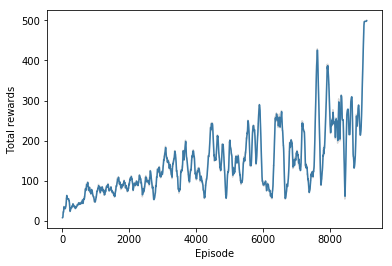

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

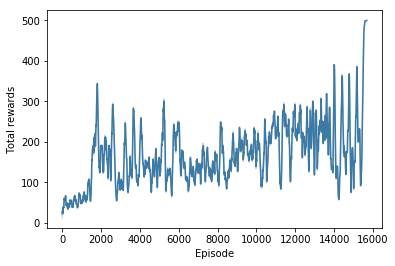

In [46]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

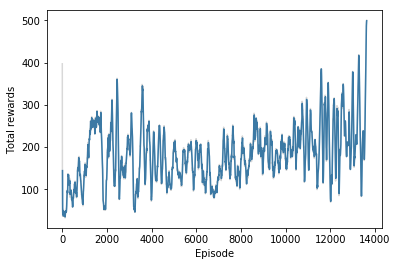

In [32]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

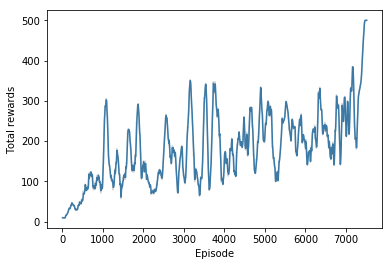

Text(0,0.5,'G losses')

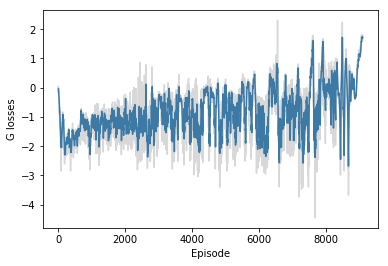

In [31]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

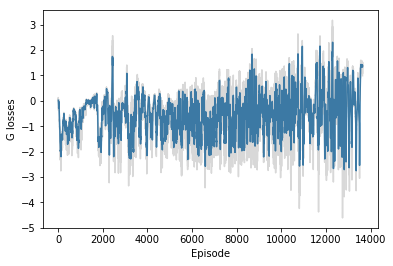

In [33]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

Text(0,0.5,'G losses')

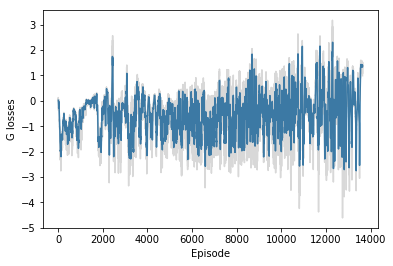

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

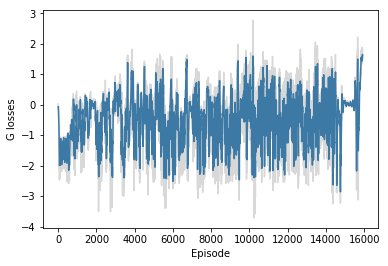
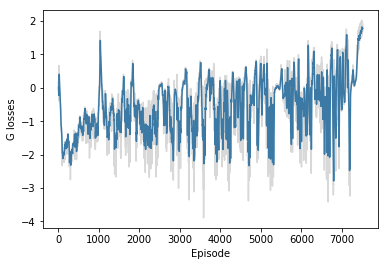

Text(0,0.5,'D losses')

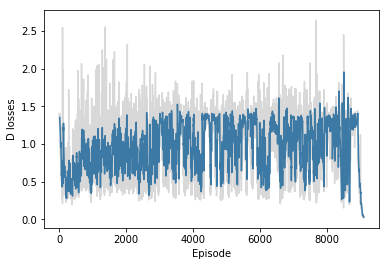

In [32]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

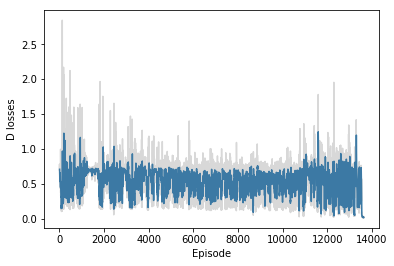

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

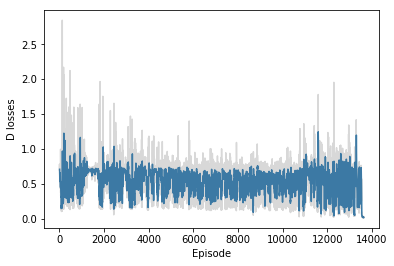

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

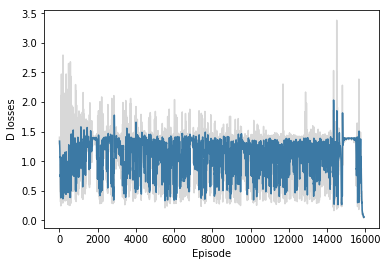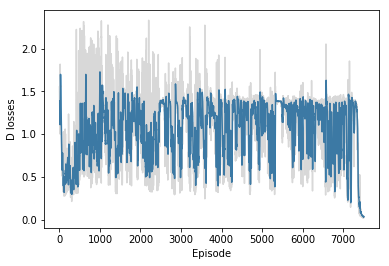

Text(0,0.5,'D losses R')

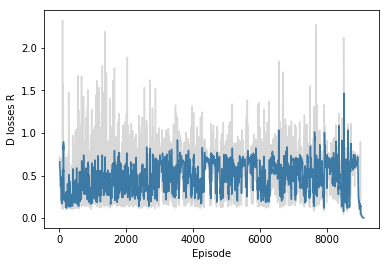

In [33]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

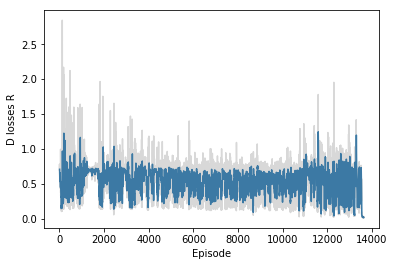

In [35]:
# eps, arr = np.array(d_lossR_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

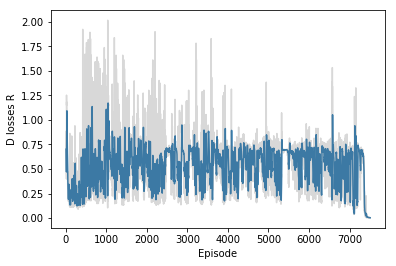

In [32]:
# eps, arr = np.array(d_lossR_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

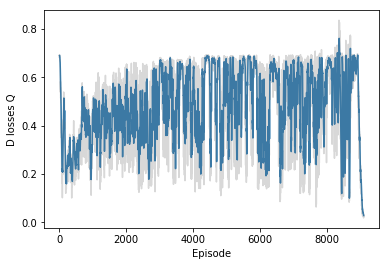

In [34]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

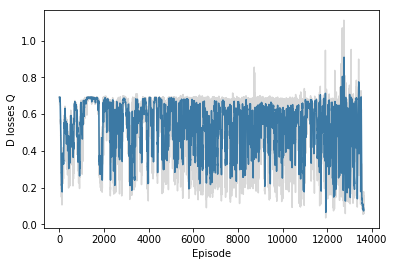

In [36]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

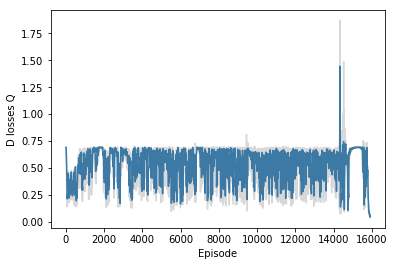

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

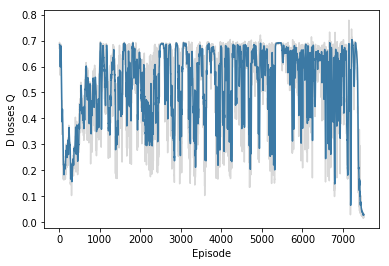

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.